# Housing Capstone Project#
## James Chiu ##

### Goal
- Can we predict trends in the housing market? (next 2-3 months)*****
- Can we predict the next months median house price?
- Is there a lag between shifts in median housing sales price compared to shifts in median rental prices? 

- (Eg. GDP, CPI, Interest Rates, Population)(separate and together)*****

### What are your metrics?

- Time Series Machine Learning that is able to reveal accurate prediction for 3-6 month lag (One for each city)(maybe pick a few)
- Does adding features relevant to the economy as a whole effect the accuracy of the model? Which features are more influential in determining housing trends? (Eg. GDP, CPI, Interest Rates, Population)
- Mean Squared Error as the primary tool for judging accuracy


# Table of Conents
- Compare models Linear Regression, ARIMA, Neural Network, Long Short Term Memory Recurrent Neural Network
- 1, 2, 3 month look ahead (show that I can use the past data to predict forward, show with 12 months data)
- Overlap 1, 2, 3 months look ahead curves (show that MSE gets larger as you predict further out)
- Predict with 3, 6, 12, 18 months of data (show that more data improves the MSE)
- Autocorrelation graph to show that there is a limit to that improvement (impact of past month data on present)
- Add interest rates, unemployment, CPI to the sale price prediction model 
- Run percentage change and difference through neural network to remove seasonality
- Arima comparison (LSTM better magnitude vs ARIMA better direction)
- (EDA) Percentage change for sales price city level migration trend (sale to rent later)
- Percentage change scatter plot, shift SF to see if can find minimum (show 1,3,6,12 month lag)

## Step 1: Reading the data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import datetime
from pandas import DataFrame
from matplotlib import pyplot

plt.style.use('ggplot') 
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima_model import ARIMA


from keras.models import model_from_json
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.regularizers import L1L2
from keras import optimizers

/Users/jameschiu/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


In [4]:
rent = pd.read_csv('median_rental_price.csv')
rent_kaggle = pd.read_csv('rentpricekaggle.csv')
median_list_price= pd.read_csv('median_list_price_city.csv')
sale_price = pd.read_csv('median_sale_price_city.csv')

fed_funds_rate = pd.read_csv('FEDFUNDS.csv')
unemployment_rate = pd.read_csv('UNRATE.csv')
cpi_rate = pd.read_csv('CPIAUCSL.csv')

# Step 1: EDA

In [5]:
# Observe the shape of the data available from Zillow datasets
# rent_kaggle has city code data for merging data and expanding model to more cities
# But rent_kaggle is missing all of 2017 data only 81 columns compared to others 
print(rent.shape)
print(rent_kaggle.shape)
print(median_list_price.shape)
print(sale_price.shape)


print(fed_funds_rate.shape)
print(unemployment_rate.shape)
print(cpi_rate.shape)

(1364, 101)
(13131, 81)
(6937, 101)
(1877, 122)
(764, 2)
(842, 2)
(853, 2)


In [6]:
# Observe the data range from 2010/01 - 2017/08 
# Nulls visible in first couple months
rent.head(2)

,RegionName,State,Metro,CountyName,SizeRank,2010-01,2010-02,2010-03,2010-04,2010-05,...,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12
0,New York,NY,New York,Queens,1,NaN,NaN,NaN,NaN,2250.0,...,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0,2985.0,2950.0,2950.0
1,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,2,NaN,NaN,NaN,NaN,NaN,...,3495.0,3500.0,3500.0,3500.0,3500.0,3550.0,3500.0,3500.0,3495.0,3500.0


In [7]:
# Observe the data range from 2010/11 - 2017/01 
# Nulls visible in first couple months
rent_kaggle.head(2)

,City Code,City,Metro,County,State,Population Rank,November 2010,December 2010,January 2011,February 2011,...,April 2016,May 2016,June 2016,July 2016,August 2016,September 2016,October 2016,November 2016,December 2016,January 2017
0,6181,New York,New York,Queens,NY,1,NaN,NaN,NaN,NaN,...,2334,2339,2345,2344,2336,2324,2318,2321,2321,2322
1,12447,Los Angeles,Los Angeles,Los Angeles,CA,2,2184.0,2184.0,2183.0,2188.0,...,2637,2662,2687,2704,2716,2723,2731,2740,2748,2753


In [8]:
# Observe the data range from 2010/01 - 2017/12 
# Nulls visible in first couple months
median_list_price.head(2)

,RegionName,State,Metro,CountyName,SizeRank,2010-01,2010-02,2010-03,2010-04,2010-05,...,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12
0,New York,NY,New York,Queens,1,NaN,NaN,NaN,NaN,NaN,...,788000.0,800000.0,850000.0,859000.0,849000.0,829999.0,839000.0,850000.0,859100.0,850000.0
1,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,2,NaN,NaN,NaN,NaN,NaN,...,720000.0,739900.0,749000.0,745000.0,740000.0,729900.0,739000.0,749000.0,749000.0,749900.0


In [9]:
# Observe the data range from 2008/03 - 2017/12 
# Nulls visible in first couple months
sale_price.head(2)

,RegionID,RegionName,StateName,SizeRank,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,...,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12
0,6181.0,New York,New York,1,NaN,NaN,NaN,NaN,NaN,NaN,...,543700.0,543600.0,553200.0,553700.0,572000.0,576100.0,572300.0,547800.0,528500.0,542000.0
1,12447.0,Los Angeles,California,2,512600.0,479200.0,460700.0,453500.0,439400.0,425700.0,...,649900.0,625200.0,631100.0,635600.0,650800.0,651400.0,651700.0,652500.0,665400.0,675500.0


In [10]:
# Observe descriptive statistics for rent
rent.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
SizeRank,1364.0,682.497067,393.896219,1.0,341.75,682.50,1023.25,1363.0
2010-01,1.0,897.500000,NaN,897.5,897.50,897.50,897.50,897.5
2010-02,27.0,1431.685185,407.486837,875.0,1151.50,1300.00,1600.00,2400.0
2010-03,62.0,1362.008065,406.304320,725.0,1056.25,1250.00,1597.50,2500.0
2010-04,76.0,1419.486842,475.525436,737.5,1050.00,1273.75,1698.75,3300.0


In [11]:
# Observe descriptive statistics for rent_kaggle
rent_kaggle.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
City Code,13131.0,78126.756454,119604.910806,3300.0,18803.00,34678.0,51385.5,737791.0
Population Rank,13131.0,6566.000000,3790.737527,1.0,3283.50,6566.0,9848.5,13131.0
November 2010,11348.0,1327.100458,652.531343,547.0,982.00,1195.0,1479.0,18787.0
December 2010,11348.0,1331.831953,655.822002,539.0,984.75,1199.0,1479.0,18848.0
January 2011,11348.0,1334.447744,653.931315,536.0,986.00,1201.5,1479.0,19054.0


In [12]:
# Observe descriptive statistics for sale_price
sale_price.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
RegionID,1877.0,60682.166755,100351.663632,3312.0,16846.0,31592.0,46734.0,737790.0
SizeRank,1877.0,939.000000,541.987546,1.0,470.0,939.0,1408.0,1877.0
2008-03,651.0,320284.024578,175943.623199,41000.0,195550.0,280500.0,396950.0,1360400.0
2008-04,651.0,313660.522273,173286.045225,41600.0,191400.0,274300.0,386950.0,1337500.0
2008-05,651.0,305690.937020,168586.421191,45600.0,188050.0,267100.0,377600.0,1387300.0


In [13]:
# Observe descriptive statistics for list_price
median_list_price.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
SizeRank,6937.0,3468.811734,2002.458003,1.0,1735.000,3469.00,5203.0,6901.0
2010-01,2350.0,254054.729149,175584.051186,59900.0,158728.875,206048.75,298375.0,2695000.0
2010-02,2369.0,253661.408400,173258.712632,59900.0,157450.000,206200.00,299000.0,2649500.0
2010-03,2415.0,252842.884886,169531.138379,59950.0,156925.000,208000.00,299000.0,2575000.0
2010-04,2437.0,250852.141773,166796.522225,59900.0,156000.000,205000.00,296500.0,2499800.0


In [14]:
# List of null columns in rent
rent_null = rent.isnull().sum()[rent.isnull().sum() > 0].index

In [15]:
rent_null

Index(['Metro', '2010-01', '2010-02', '2010-03', '2010-04', '2010-05',
       '2010-06', '2010-07', '2010-08', '2010-09', '2010-10', '2010-11',
       '2010-12', '2011-01', '2011-02', '2011-03', '2011-04', '2011-05',
       '2011-06', '2011-07', '2011-08', '2011-09', '2011-10', '2011-11',
       '2011-12', '2012-01', '2012-02', '2012-03', '2012-04', '2012-05',
       '2012-06', '2012-07', '2012-08', '2012-09', '2012-10', '2012-11',
       '2012-12', '2013-01', '2013-02', '2013-03', '2013-04', '2013-05',
       '2013-06', '2013-07', '2013-08', '2013-09', '2013-10', '2013-11',
       '2013-12', '2014-01', '2014-02', '2014-03', '2014-04', '2014-05',
       '2014-06', '2014-07', '2014-08', '2014-09', '2014-10', '2014-11',
       '2014-12', '2015-01', '2015-02', '2015-03', '2015-04', '2015-05',
       '2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11',
       '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05',
       '2016-06', '2016-07', '2016-08', '2016-09', '2

In [16]:
# List of null columns in rent_kaggle
rent_kaggle_null = rent_kaggle.isnull().sum()[rent_kaggle.isnull().sum() > 0].index

In [17]:
rent_kaggle_null

Index(['Metro', 'November 2010', 'December 2010', 'January 2011',
       'February 2011', 'March 2011', 'April 2011', 'May 2011', 'June 2011',
       'July 2011', 'August 2011', 'September 2011', 'October 2011',
       'November 2011', 'December 2011', 'January 2012', 'February 2012',
       'March 2012'],
      dtype='object')

In [18]:
# List of null columns in list_price
list_price_null = median_list_price.isnull().sum()[median_list_price.isnull().sum() > 0].index

In [19]:
list_price_null

Index(['Metro', '2010-01', '2010-02', '2010-03', '2010-04', '2010-05',
       '2010-06', '2010-07', '2010-08', '2010-09', '2010-10', '2010-11',
       '2010-12', '2011-01', '2011-02', '2011-03', '2011-04', '2011-05',
       '2011-06', '2011-07', '2011-08', '2011-09', '2011-10', '2011-11',
       '2011-12', '2012-01', '2012-02', '2012-03', '2012-04', '2012-05',
       '2012-06', '2012-07', '2012-08', '2012-09', '2012-10', '2012-11',
       '2012-12', '2013-01', '2013-02', '2013-03', '2013-04', '2013-05',
       '2013-06', '2013-07', '2013-08', '2013-09', '2013-10', '2013-11',
       '2013-12', '2014-01', '2014-02', '2014-03', '2014-04', '2014-05',
       '2014-06', '2014-07', '2014-08', '2014-09', '2014-10', '2014-11',
       '2014-12', '2015-01', '2015-02', '2015-03', '2015-04', '2015-05',
       '2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11',
       '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05',
       '2016-06', '2016-07', '2016-08', '2016-09', '2

In [20]:
# List of null columns in sale_price
sale_price.isnull().sum()[sale_price.isnull().sum() > 0].index

Index(['2008-03', '2008-04', '2008-05', '2008-06', '2008-07', '2008-08',
       '2008-09', '2008-10', '2008-11', '2008-12',
       ...
       '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08',
       '2017-09', '2017-10', '2017-11', '2017-12'],
      dtype='object', length=104)

In [21]:
# Create an index to drop columns that have null values
# Nest another list to keep certain columns (ie.'2017-12', rent_null) to avoid dropping too many cities 
# Currently using rent_null as a proxy for the list of null columns
index_to_drop = rent.isnull().sum(axis=1)[rent.drop(rent_null,axis=1).isnull().sum(axis=1)>0].index

# Drop columns and specify the state which I want to focus on in analysis
# Assign new dataframe to variable df for analysis
rent_df = rent.drop(index_to_drop, axis=0)[rent.State=='OR']

In [22]:
rent_df.head(2)

,RegionName,State,Metro,CountyName,SizeRank,2010-01,2010-02,2010-03,2010-04,2010-05,...,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12
29,Portland,OR,Portland,Multnomah,30,NaN,NaN,NaN,NaN,NaN,...,1850.0,1895.0,1895.0,1995.0,1975.0,1950.0,1895.0,1895.0,1850.0,1895.0
180,Salem,OR,Salem,Marion,181,NaN,NaN,NaN,NaN,NaN,...,1400.0,1395.0,1395.0,1395.0,1397.5,1475.0,1500.0,1500.0,1462.5,1442.5


In [23]:
# Create an index to drop columns that have null values
# Nest another list to keep certain columns (ie.'2017-12', rent_kaggle_null) to avoid dropping too many cities 
# Currently using rent_null as a proxy for the list of null columns
index_to_drop = rent_kaggle.isnull().sum(axis=1)[rent_kaggle.drop(rent_kaggle_null,axis=1).isnull().sum(axis=1)>0].index

# Drop columns and specify the state which I want to focus on in analysis
# Assign new dataframe to variable df for analysis
rent_kaggle_df = rent_kaggle.drop(index_to_drop, axis=0)[rent_kaggle.State=='OR']

In [24]:
rent_kaggle_df.head(2)

,City Code,City,Metro,County,State,Population Rank,November 2010,December 2010,January 2011,February 2011,...,April 2016,May 2016,June 2016,July 2016,August 2016,September 2016,October 2016,November 2016,December 2016,January 2017
29,13373,Portland,Portland,Multnomah,OR,30,1280.0,1286.0,1292.0,1296.0,...,1801,1815,1827,1832,1830,1834,1844,1857,1861,1859
185,20317,Salem,Salem,Marion,OR,186,988.0,992.0,1001.0,1015.0,...,1377,1391,1403,1413,1420,1425,1429,1436,1442,1449


In [25]:
# Create an index to drop columns that have null values
# Nest another list to keep certain columns (ie.'2017-12', list_price_null) to avoid dropping too many cities 
# Currently using list_price_null as a proxy for the list of null columns
index_to_drop = median_list_price.isnull().sum(axis=1)[median_list_price.drop(list_price_null,axis=1).isnull().sum(axis=1)>0].index

# Drop columns and specify the state which I want to focus on in analysis
# Assign new dataframe to variable df for analysis
list_price_df = median_list_price.drop(index_to_drop, axis=0)[median_list_price.State=='OR']

In [26]:
list_price_df.head(2)

,RegionName,State,Metro,CountyName,SizeRank,2010-01,2010-02,2010-03,2010-04,2010-05,...,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12
28,Portland,OR,Portland,Multnomah,29,NaN,NaN,NaN,NaN,NaN,...,420000.0,429900.0,439000.0,439700.0,435000.0,429000.0,425000.0,426720.0,425000.0,425000.0
186,Salem,OR,Salem,Marion,187,199900.0,197900.0,189900.0,189850.0,189500.0,...,259000.0,265000.0,269900.0,252950.0,270000.0,269000.0,269900.0,280800.0,289900.0,290000.0


In [27]:
# Create an index to drop columns that have null values
# Nest another list to keep certain columns (ie.'2017-12') to avoid dropping too many cities 
index_to_drop = sale_price.isnull().sum(axis=1)[sale_price.drop(['2017-12'],axis=1).isnull().sum(axis=1)>0].index

# Drop columns and specify the state which I want to focus on in analysis
# Assign new dataframe to variable df for analysis
df = sale_price.drop(index_to_drop, axis=0)[sale_price.StateName=='Oregon']

/Users/jameschiu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


In [28]:
df.head()

,RegionID,RegionName,StateName,SizeRank,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,...,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12
24,13373.0,Portland,Oregon,25,288100.0,278800.0,277200.0,278000.0,283000.0,283900.0,...,389300.0,384500.0,390400.0,387900.0,392000.0,384700.0,390300.0,391100.0,392100.0,386500.0
195,30381.0,Beaverton,Oregon,196,270600.0,269300.0,271300.0,254000.0,257200.0,248100.0,...,324300.0,319500.0,323600.0,324700.0,333100.0,332800.0,335900.0,339000.0,333200.0,330300.0
346,24967.0,Gresham,Oregon,347,250000.0,244200.0,240300.0,237700.0,235600.0,228300.0,...,295000.0,299200.0,299400.0,309100.0,306700.0,308300.0,304700.0,310700.0,310400.0,320700.0
495,30177.0,Aloha,Oregon,496,260200.0,255100.0,248100.0,252600.0,248800.0,240900.0,...,331600.0,336900.0,332800.0,328900.0,326100.0,326300.0,327400.0,324300.0,327400.0,336800.0
526,9662.0,Oregon City,Oregon,527,304700.0,290900.0,286400.0,276000.0,275900.0,266800.0,...,362200.0,369800.0,355200.0,356400.0,361700.0,368300.0,383000.0,370100.0,362600.0,365400.0


In [29]:
ca_df = sale_price.drop(index_to_drop, axis=0)[sale_price.StateName=='California']
ca_df.head()

/Users/jameschiu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,RegionID,RegionName,StateName,SizeRank,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,...,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12
1,12447.0,Los Angeles,California,2,512600.0,479200.0,460700.0,453500.0,439400.0,425700.0,...,649900.0,625200.0,631100.0,635600.0,650800.0,651400.0,651700.0,652500.0,665400.0,675500.0
7,54296.0,San Diego,California,8,425400.0,412700.0,399100.0,378200.0,369200.0,355600.0,...,551100.0,543900.0,534300.0,537200.0,547100.0,553600.0,553300.0,548700.0,562200.0,569000.0
9,33839.0,San Jose,California,10,634200.0,598500.0,568200.0,540500.0,524500.0,512100.0,...,841400.0,834400.0,817000.0,812000.0,821400.0,830800.0,849500.0,874800.0,899800.0,941800.0
11,20330.0,San Francisco,California,12,788400.0,775400.0,767300.0,763800.0,777000.0,788900.0,...,1108800.0,1163100.0,1160300.0,1186100.0,1207700.0,1242200.0,1253200.0,1278700.0,1270600.0,NaN
28,20288.0,Sacramento,California,29,207000.0,188400.0,173000.0,164800.0,158200.0,150100.0,...,282500.0,281200.0,284900.0,281000.0,284500.0,285500.0,282200.0,281000.0,290500.0,299800.0


# Feature Engineering

In [30]:
# Create a dataframe from new sale_price df
# reset the index of dates into a column and change label
portland = pd.DataFrame(df.iloc[0, 4:])
portland.reset_index(inplace=True)  
portland.columns = ['month', 'portland']
portland.head(2)

,month,portland
0,2008-03,288100
1,2008-04,278800


In [31]:
portland.tail(2)

,month,portland
116,2017-11,392100
117,2017-12,386500


In [32]:
# Save a copy of the time series data for future adjustments in the LSTM-RNN
portland_rnn = portland
portland_rnn.head(2)

,month,portland
0,2008-03,288100
1,2008-04,278800


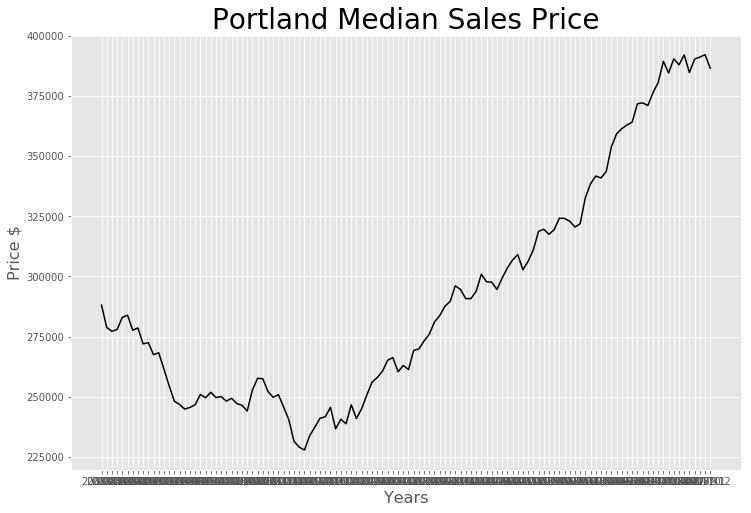

In [33]:
# Observe the data and it's trend
plt.figure(figsize=(12,8))
plt.title('Portland Median Sales Price', fontsize=28)
plt.ylabel('Price $', fontsize=16)
plt.xlabel('Years', fontsize=16)
plt.plot(portland_rnn['month'], portland_rnn['portland'], color='black')
# plt.legend(portland_rnn,loc='upper left')
plt.savefig('Portland Median Sales Price.jpg');

# plt.plot(portland_rnn['portland'])

In [34]:
# Convert the month column into data time format
# Convert portland into integer format
portland['month'] = pd.to_datetime(portland['month'])
portland['portland'] = portland['portland'].astype(int)
portland.dtypes

month       datetime64[ns]
portland             int64
dtype: object

In [35]:
# Set the index back to the date time info
portland = portland.set_index('month')

In [36]:
# Data looks ready for time series analysis
portland.head(5)

,portland
month,
2008-03-01,288100
2008-04-01,278800
2008-05-01,277200
2008-06-01,278000
2008-07-01,283000


In [37]:
# Check shape 
portland.shape

(118, 1)

In [38]:
# Create a function to shift the dataframe by duration (number of months of data for prediction)
# In this case we are using 6 months of data for the prediction 

def dataout(duration):
    for i in range (1, duration+1):
        j = -1 * i 
        if i == (duration):
            portland['predict'] = portland['portland'].shift(j) 
        else:
            portland[i] = portland['portland'].shift(j) 
    return portland

cc = dataout(6)
cc.dropna(axis=0, inplace=True)
cc.tail(10)
portland_6_month = cc
# portland = cc.iloc[:-6]

In [39]:
# Lost 6 months of data to create the 6 month shift in time series data
portland_6_month.shape

(112, 7)

In [40]:
# Check the tail to see that the data is in the correct format
portland_6_month.tail(7)

# see if strong correlation GDP
# keep less features for lower amount of rows 
# curse of dimensionality

,portland,1,2,3,4,5,predict
month,,,,,,,
2016-12-01,371000,376300.0,380600.0,389300.0,384500.0,390400.0,387900.0
2017-01-01,376300,380600.0,389300.0,384500.0,390400.0,387900.0,392000.0
2017-02-01,380600,389300.0,384500.0,390400.0,387900.0,392000.0,384700.0
2017-03-01,389300,384500.0,390400.0,387900.0,392000.0,384700.0,390300.0
2017-04-01,384500,390400.0,387900.0,392000.0,384700.0,390300.0,391100.0
2017-05-01,390400,387900.0,392000.0,384700.0,390300.0,391100.0,392100.0
2017-06-01,387900,392000.0,384700.0,390300.0,391100.0,392100.0,386500.0


In [41]:
# Renaming columns
# portland_6_month.columns[0:6] = [col for col in portland_6_month.columns[0:6]]
# print(list(range(-6, 0)))
portland_6_month.rename(columns={'portland': 'pdx -6', 1:'pdx -5', 2:'pdx -4', 3:'pdx -3', 
                                  4:'pdx -2', 5:'pdx -1'}, inplace=True)

In [42]:
portland_6_month.tail(8)

,pdx -6,pdx -5,pdx -4,pdx -3,pdx -2,pdx -1,predict
month,,,,,,,
2016-11-01,372100,371000.0,376300.0,380600.0,389300.0,384500.0,390400.0
2016-12-01,371000,376300.0,380600.0,389300.0,384500.0,390400.0,387900.0
2017-01-01,376300,380600.0,389300.0,384500.0,390400.0,387900.0,392000.0
2017-02-01,380600,389300.0,384500.0,390400.0,387900.0,392000.0,384700.0
2017-03-01,389300,384500.0,390400.0,387900.0,392000.0,384700.0,390300.0
2017-04-01,384500,390400.0,387900.0,392000.0,384700.0,390300.0,391100.0
2017-05-01,390400,387900.0,392000.0,384700.0,390300.0,391100.0,392100.0
2017-06-01,387900,392000.0,384700.0,390300.0,391100.0,392100.0,386500.0


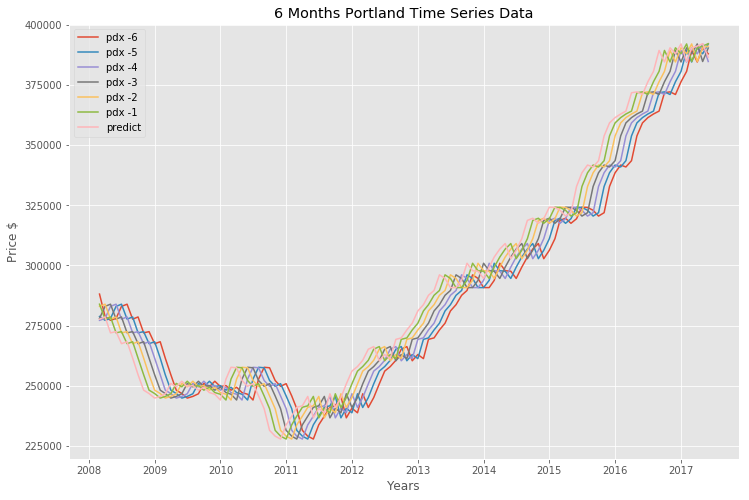

In [43]:
plt.figure(figsize=(12,8))
plt.title('6 Months Portland Time Series Data')
plt.ylabel('Price $')
plt.xlabel('Years')
plt.plot(portland_6_month)
plt.legend(portland_6_month,loc='upper left')
plt.savefig('6 Months Portland Time Series Data.jpg');

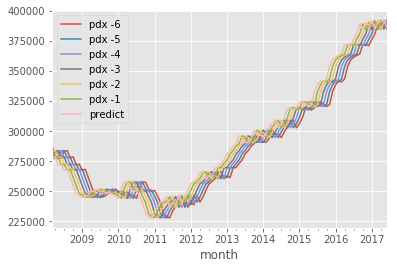

In [44]:
plt.figure(figsize=(12,8))
portland_6_month.plot.line();

In [45]:
# Select n months of lag data as features for independent variable
portland_6_month.iloc[:,:6].head(5)

,pdx -6,pdx -5,pdx -4,pdx -3,pdx -2,pdx -1
month,,,,,,
2008-03-01,288100,278800.0,277200.0,278000.0,283000.0,283900.0
2008-04-01,278800,277200.0,278000.0,283000.0,283900.0,277700.0
2008-05-01,277200,278000.0,283000.0,283900.0,277700.0,278600.0
2008-06-01,278000,283000.0,283900.0,277700.0,278600.0,272000.0
2008-07-01,283000,283900.0,277700.0,278600.0,272000.0,272500.0


In [46]:
# Assign the values to X and y variables
# The predict column(y) and the shifted data(X)
X = portland_6_month.iloc[:,0:6]
y = portland_6_month[['predict']]

# Linear Regression

/Users/jameschiu/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


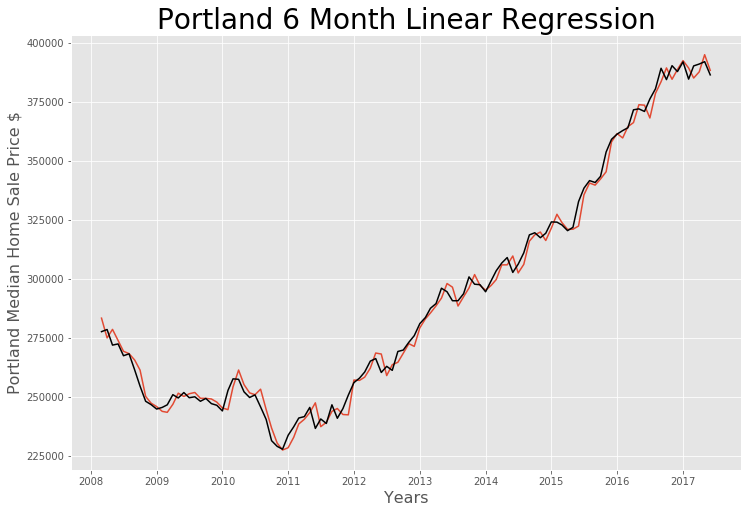

In [47]:
# Assign the values to X and y variables
# The predict column(y) and the shifted data(X)
X = portland_6_month.iloc[:,0:6]
y = portland_6_month[['predict']]

# assign the real sale price to a variable
y_real = y['predict'].as_matrix()

# Train test split, don't shuffle the data for time series
# Scale the data
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False) 
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

# Instantiate the Linear Regression and fit the model
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_prediction=lr.predict(X)

# Plot the linear regression predictions against the real
plt.figure(figsize=(12,8))
plt.title('Portland 6 Month Linear Regression', fontsize=28)
plt.ylabel('Portland Median Home Sale Price $', fontsize=16)
plt.xlabel('Years', fontsize=16)
plt.plot(portland_6_month.index.values, lr_prediction[0:])
plt.plot(portland_6_month.index.values, y_real, color='black')
plt.savefig('Linear Regression 6 month.jpg');

In [48]:
print("Score: %.4f" %lr.score(X_test ,y_test))
print("MSE: %.2f" %mean_squared_error(y_test, lr.predict(X_test)))
print("Error: $%.2f" %(np.sqrt(mean_squared_error(y_test, lr.predict(X_test)))))
print(lr.coef_)
print(lr.intercept_)
# print(lr.predict([[0, 0, 0, 0, 0, 0]]))
# %s is for names and %d is for numbers in print statement

Score: 0.9693
MSE: 16884957.21
Error: $4109.13
[[-0.13329669 -0.14022416  0.60811321 -0.56847204  0.01461488  1.21121477]]
[ 2388.07880822]


- The linear regression does a good job fitting the data 
- The prediction for the next month using previous 6 months of data has a score of 0.9693
- Observing the plot, the prediction does a good job of following the line

# ARIMA Portland 6 months, 1 month diff, 0 ma

In [49]:
# Create a dataframe from new sale_price df
# reset the index of dates into a column and change label
portland = pd.DataFrame(df.iloc[0, 4:])
portland.reset_index(inplace=True)  
portland.columns = ['month', 'portland']


# Convert the month column into data time format
# Convert portland into integer format
portland['month'] = pd.to_datetime(portland['month'])
portland['portland'] = portland['portland'].astype(int)

# Set the index back to the date time info
portland = portland.set_index('month')

# Convert data to float for the ARIMA model
portland['portland'] = portland['portland'].astype(float)

print(portland.tail(2))
print(portland.shape)
print(portland.dtypes)
# Check shape & data types
# Data looks ready for time series analysis

            portland
month               
2017-11-01  392100.0
2017-12-01  386500.0
(118, 1)
portland    float64
dtype: object


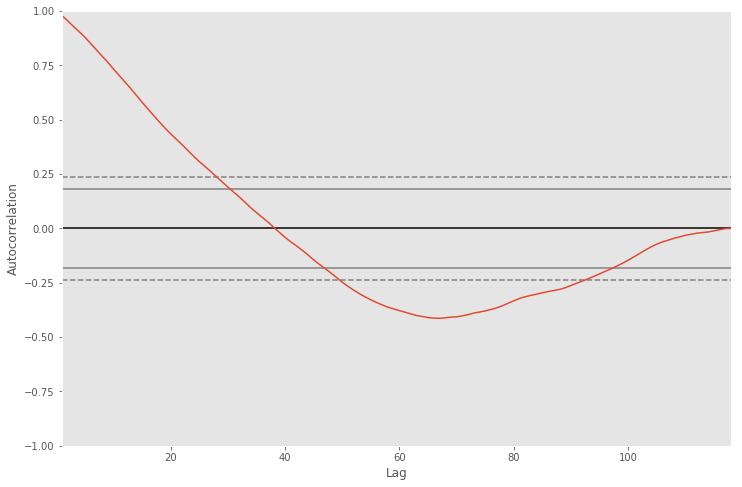

In [50]:
# Observe autocorrelation(impact of past month data on present)
plt.figure(figsize=(12,8))
# plt.title('Autocorrelation - Impact of past prices on present price')
pd.plotting.autocorrelation_plot(portland)
plt.savefig('Autocorrelation Portland.jpeg');

                             ARIMA Model Results                              
Dep. Variable:             D.portland   No. Observations:                  117
Model:                 ARIMA(6, 1, 0)   Log Likelihood               -1127.048
Method:                       css-mle   S.D. of innovations           3671.245
Date:                Tue, 24 Apr 2018   AIC                           2270.097
Time:                        18:00:31   BIC                           2292.194
Sample:                    04-01-2008   HQIC                          2279.068
                         - 12-01-2017                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              789.9397    584.706      1.351      0.179    -356.062    1935.942
ar.L1.D.portland     0.2137      0.091      2.341      0.021       0.035       0.393
ar.L2.D.portland     0.2678 

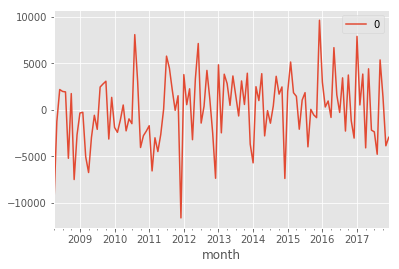

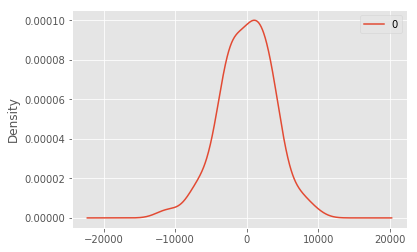

                  0
count    117.000000
mean       9.128565
std     3726.394720
min   -11634.783342
25%    -2422.848084
50%      303.698562
75%     2464.065554
max     9642.135238


In [51]:
from statsmodels.tsa.arima_model import ARIMA
 
# fit model
model = ARIMA(portland, order=(6,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())


# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

predicted=296878.931172, expected=299300.000000
predicted=299392.316259, expected=303500.000000
predicted=306603.440420, expected=306800.000000
predicted=306167.698048, expected=309100.000000
predicted=310086.455580, expected=302800.000000
predicted=302042.539708, expected=306300.000000
predicted=305920.211616, expected=311100.000000
predicted=316436.753440, expected=318700.000000
predicted=319171.995342, expected=319600.000000
predicted=319971.764542, expected=317500.000000
predicted=316021.718607, expected=319400.000000
predicted=321810.659910, expected=324200.000000
predicted=328118.227312, expected=324100.000000
predicted=324114.748160, expected=322900.000000
predicted=321271.160356, expected=320500.000000
predicted=321424.779434, expected=321900.000000
predicted=322923.586760, expected=332800.000000
predicted=336487.695559, expected=338500.000000
predicted=340920.294151, expected=341700.000000
predicted=339651.219154, expected=340900.000000
predicted=342551.797600, expected=343500

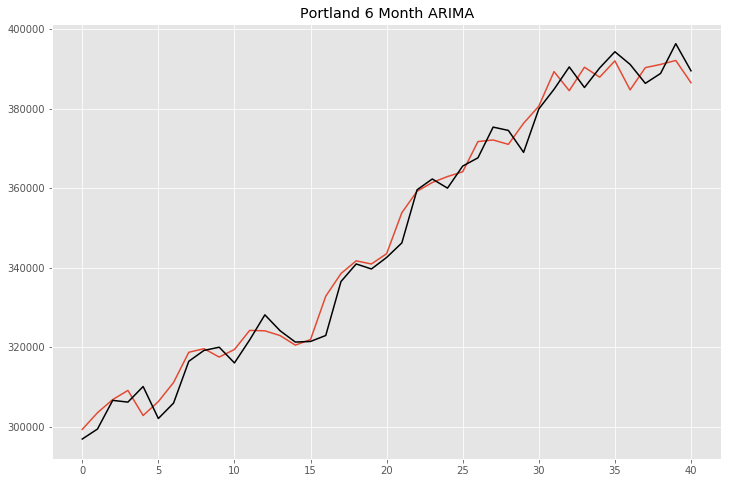

In [52]:
X = portland.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
print('Error: $%0.2f' %np.sqrt(error))
# plot
pyplot.figure(figsize=(12, 8))
plt.title('Portland 6 Month ARIMA')
pyplot.plot(test)
pyplot.plot(predictions, color='black')
plt.savefig('ARIMA 6 month.jpg')
pyplot.show()

# Neural Network

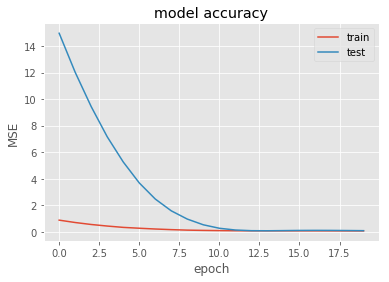

In [53]:
# Assign the values to X and y variables
# The predict column(y) and the shifted data(X)
X = portland_6_month.iloc[:,0:6]
y = portland_6_month[['predict']]

# assign the real sale price to a variable
y_real = y['predict'].as_matrix()

# Train test split, don't shuffle the data for time series
# Scale the data
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False) 

ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)
y_train_sc = ss.fit_transform(y_train)
y_test_sc = ss.transform(y_test)

# Neural Network using 6 month lag data to predict next month
model = Sequential()
model.add(Dense(60, activation='relu', input_dim=X_train.shape[1]))
# model.add(Dense(7, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

history = model.fit(X_train_sc, y_train_sc, validation_data=(X_test_sc, y_test_sc), epochs=20, verbose=0)

# list all data in history
# print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model accuracy')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Riley Recs
# sklearn wrapper gridsearch (for loop for neurons and epochs )
# percent change knock out dollars, stocks diff val same
# percent change LT inflation
# limited amount data for increaseing layers

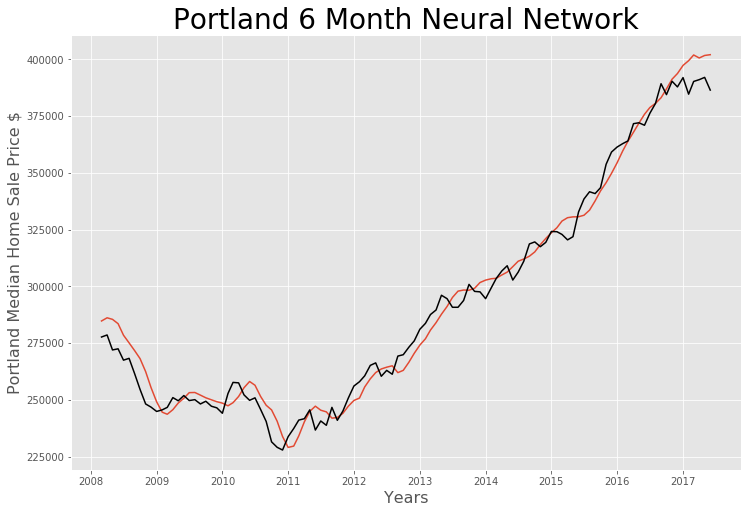

In [54]:
# Transform train data back to previous format
nn_train_prediction = ss.inverse_transform(model.predict(X_train_sc))

# Transform test data back to previous format
nn_test_prediction = ss.inverse_transform(model.predict(X_test_sc))

# Concatenate the train and test predictions for plotting
nn_pred = pd.concat([pd.DataFrame(nn_train_prediction, index=(X_train.index)), 
                     pd.DataFrame(nn_test_prediction, index=(X_test.index))])

# Check length of the predictions 
# len(nn_pred)

# Observe the portland index
# portland.index

# Reset index for the predictions to double check the accuracy of dates
nn_pred = nn_pred.reset_index()
# nn_pred.head()

# drop the month to conform with format of plot
nn_pred.drop(['month'], axis=1, inplace=True)

# Plot the predictions against the real data
plt.figure(figsize=(12,8))
plt.title('Portland 6 Month Neural Network', fontsize=28)
plt.ylabel('Portland Median Home Sale Price $', fontsize=16)
plt.xlabel('Years', fontsize=16)
plt.plot(portland_6_month.index, nn_pred)
plt.plot(portland_6_month.index, y_real, color='black')
plt.savefig('Neural Network 6 month.jpg');

In [55]:
print("Error: $%0.2f" % np.sqrt(ss.inverse_transform(history.history['loss']).sum()))

Error: $2339.46


- The model loss converges for the Neural Network
- It follows the same trend real data quite well, but isn't as accurate near the end
- This may be due to lack of adjustment for seasonality in the data
- Seasonality will be an action area for next iteration

# Recurrent Neural Network - Long Short Term Memory

Epoch 1/20
84/84 [==============================] - 0s 3ms/step - loss: 0.9946 - mean_squared_error: 0.9946
Epoch 2/20
84/84 [==============================] - 0s 463us/step - loss: 0.5430 - mean_squared_error: 0.5430
Epoch 3/20
84/84 [==============================] - 0s 526us/step - loss: 0.1649 - mean_squared_error: 0.1649
Epoch 4/20
84/84 [==============================] - 0s 480us/step - loss: 0.0964 - mean_squared_error: 0.0964
Epoch 5/20
84/84 [==============================] - 0s 455us/step - loss: 0.2466 - mean_squared_error: 0.2466
Epoch 6/20
84/84 [==============================] - 0s 453us/step - loss: 0.2145 - mean_squared_error: 0.2145
Epoch 7/20
84/84 [==============================] - 0s 457us/step - loss: 0.1108 - mean_squared_error: 0.1108
Epoch 8/20
84/84 [==============================] - 0s 584us/step - loss: 0.0602 - mean_squared_error: 0.0602
Epoch 9/20
84/84 [==============================] - 0s 540us/step - loss: 0.0720 - mean_squared_error: 0.0720
Epoch 10/20


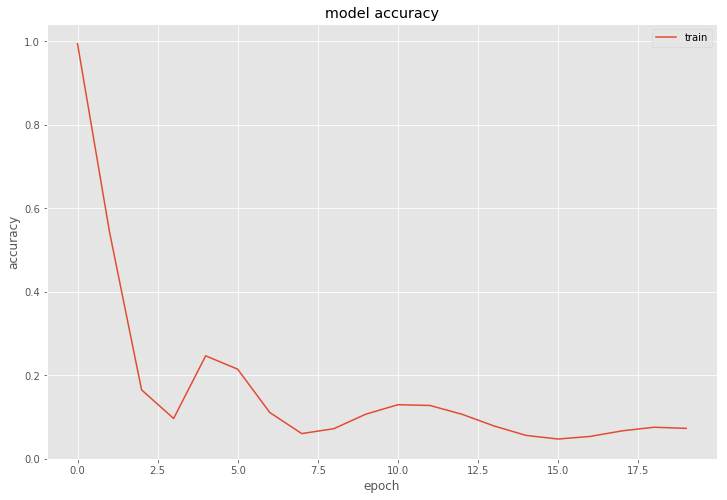

In [56]:
# Assign the values to X and y variables
# The predict column(y) and the shifted data(X)
# Train test split, don't shuffle the data for time series
# Scale the data
X = portland_6_month.iloc[:,0:6]
y = portland_6_month[['predict']]
y_real = y['predict'].as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False) 

ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

y_train_sc = ss.fit_transform(y_train)
y_test_sc = ss.transform(y_test)

# Reshape the data into 3d for the RNN-LSTM model
X_train_sc = X_train_sc.reshape(X_train_sc.shape[0], X_train_sc.shape[1], 1)
X_test_sc = X_test_sc.reshape(X_test_sc.shape[0], X_test_sc.shape[1], 1)

model = Sequential()
model.add(LSTM(200, activation='tanh', input_shape=(X_train_sc.shape[1], 1) ))
model.add(Dense(200, activation='tanh'))
model.add(Dense(1, activation='linear'))
adam = optimizers.adam(lr=0.002,decay=0.0002)
model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mean_squared_error'])

history_portland_6_month = model.fit(X_train_sc, y_train_sc, epochs = 20, batch_size=len(X), shuffle=False, verbose=1)

# list all data in history
# print(history_portland_6_month.history.keys())

# summarize history for accuracy
plt.figure(figsize=(12,8))
plt.plot(history_portland_6_month.history['mean_squared_error'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# more layers helps
# more neurons helps
# too many neurons hurts, too many layers may not help
# play with the activation function, regression vs classification important
# how to get performance better tune:  layers, epochs & neurons
# diminishing returns after a certain number of neurons

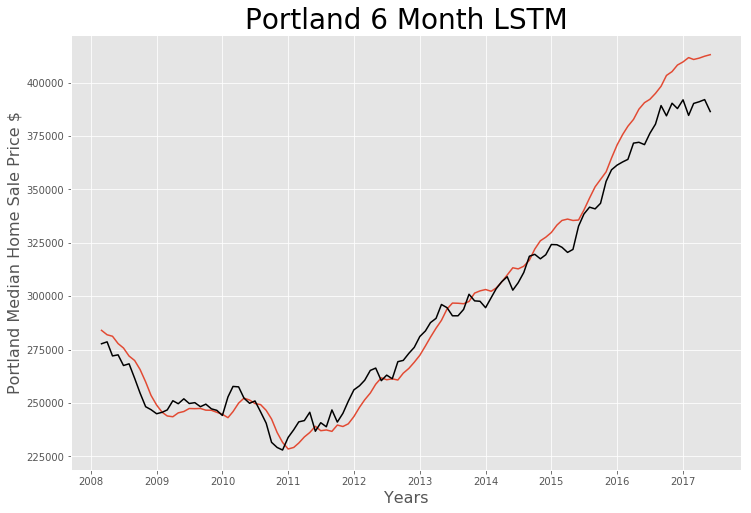

In [57]:
# Transform train data back to previous format
lstm_train_prediction = ss.inverse_transform(model.predict(X_train_sc))

# Transform test data back to previous format
lstm_test_prediction = ss.inverse_transform(model.predict(X_test_sc))

# Concatenate the train and test predictions for plotting
lstm_pred = pd.concat([pd.DataFrame(lstm_train_prediction, index=(X_train.index)), 
                       pd.DataFrame(lstm_test_prediction, index=(X_test.index))])

# Check length of the predictions 
# len(lstm_pred)

# Check the index from portland
# portland.index

# Reset index for the predictions to double check the accuracy of dates
lstm_pred = lstm_pred.reset_index()
# lstm_pred.head()

# drop the month to conform with format of plot
lstm_pred.drop(['month'], axis=1, inplace=True)

plt.figure(figsize=(12,8))
plt.title('Portland 6 Month LSTM')
plt.title('Portland 6 Month LSTM', fontsize=28)
plt.ylabel('Portland Median Home Sale Price $', fontsize=16)
plt.xlabel('Years', fontsize=16)
plt.plot(portland_6_month.index, lstm_pred)
plt.plot(portland_6_month.index, y_real, color='black')
plt.savefig('LSTM 6 month.jpg');

In [58]:
print("Error: $%0.2f" % np.sqrt(ss.inverse_transform(history_portland_6_month.history['mean_squared_error']).sum()))

Error: $2334.22


- The LSTM - RNN model is able to follow the trend as observed in the graph 
- But there is a gap in the points 18-50 where the predictions flat line
- This may be a result of a leakage in data
- Action item double check the format of the data and rerun the model after adjustment

# RNN - LSTM Pct Change (Seasonality)

In [59]:
portland_6_month_pct_change = portland_6_month.pct_change().dropna()

In [60]:
portland_6_month.head()

,pdx -6,pdx -5,pdx -4,pdx -3,pdx -2,pdx -1,predict
month,,,,,,,
2008-03-01,288100,278800.0,277200.0,278000.0,283000.0,283900.0,277700.0
2008-04-01,278800,277200.0,278000.0,283000.0,283900.0,277700.0,278600.0
2008-05-01,277200,278000.0,283000.0,283900.0,277700.0,278600.0,272000.0
2008-06-01,278000,283000.0,283900.0,277700.0,278600.0,272000.0,272500.0
2008-07-01,283000,283900.0,277700.0,278600.0,272000.0,272500.0,267500.0


In [61]:
portland_6_month_pct_change.head()

,pdx -6,pdx -5,pdx -4,pdx -3,pdx -2,pdx -1,predict
month,,,,,,,
2008-04-01,-0.032280,-0.005739,0.002886,0.017986,0.003180,-0.021839,0.003241
2008-05-01,-0.005739,0.002886,0.017986,0.003180,-0.021839,0.003241,-0.023690
2008-06-01,0.002886,0.017986,0.003180,-0.021839,0.003241,-0.023690,0.001838
2008-07-01,0.017986,0.003180,-0.021839,0.003241,-0.023690,0.001838,-0.018349
2008-08-01,0.003180,-0.021839,0.003241,-0.023690,0.001838,-0.018349,0.002991


Epoch 1/20
83/83 [==============================] - 0s 4ms/step - loss: 0.9951 - mean_squared_error: 0.9951
Epoch 2/20
83/83 [==============================] - 0s 474us/step - loss: 0.9686 - mean_squared_error: 0.9686
Epoch 3/20
83/83 [==============================] - 0s 453us/step - loss: 0.9728 - mean_squared_error: 0.9728
Epoch 4/20
83/83 [==============================] - 0s 450us/step - loss: 0.9647 - mean_squared_error: 0.9647
Epoch 5/20
83/83 [==============================] - 0s 450us/step - loss: 0.9570 - mean_squared_error: 0.9570
Epoch 6/20
83/83 [==============================] - 0s 451us/step - loss: 0.9560 - mean_squared_error: 0.9560
Epoch 7/20
83/83 [==============================] - 0s 454us/step - loss: 0.9583 - mean_squared_error: 0.9583
Epoch 8/20
83/83 [==============================] - 0s 512us/step - loss: 0.9592 - mean_squared_error: 0.9592
Epoch 9/20
83/83 [==============================] - 0s 532us/step - loss: 0.9578 - mean_squared_error: 0.9578
Epoch 10/20


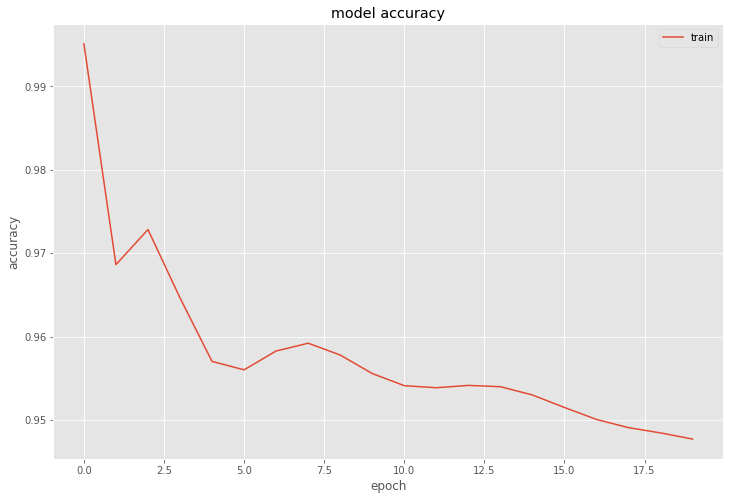

In [62]:
# Assign the values to X and y variables
# The predict column(y) and the shifted data(X)
# Train test split, don't shuffle the data for time series
# Scale the data
X = portland_6_month_pct_change.iloc[:,0:6]
y = portland_6_month_pct_change[['predict']]
y_real = y['predict'].as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False) 

ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

y_train_sc = ss.fit_transform(y_train)
y_test_sc = ss.transform(y_test)

# Reshape the data into 3d for the RNN-LSTM model
X_train_sc = X_train_sc.reshape(X_train_sc.shape[0], X_train_sc.shape[1], 1)
X_test_sc = X_test_sc.reshape(X_test_sc.shape[0], X_test_sc.shape[1], 1)

model = Sequential()
model.add(LSTM(200, activation='tanh', input_shape=(X_train_sc.shape[1], 1) ))
model.add(Dense(200, activation='tanh'))
model.add(Dense(1, activation='linear'))
adam = optimizers.adam(lr=0.002,decay=0.0002)
model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mean_squared_error'])

history_portland_6_month_pct_change = model.fit(X_train_sc, y_train_sc, epochs = 20, batch_size=len(X), shuffle=False, verbose=1)

# list all data in history
# print(history_portland_6_month.history.keys())

# summarize history for accuracy
plt.figure(figsize=(12,8))
plt.plot(history_portland_6_month_pct_change.history['mean_squared_error'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# more layers helps
# more neurons helps
# too many neurons hurts, too many layers may not help
# play with the activation function, regression vs classification important
# how to get performance better tune:  layers, epochs & neurons
# diminishing returns after a certain number of neurons

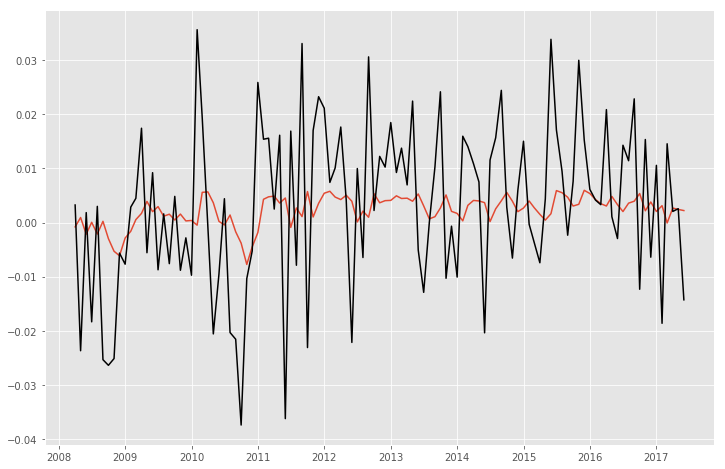

In [63]:
# Transform train data back to previous format
lstm_train_prediction = ss.inverse_transform(model.predict(X_train_sc))

# Transform test data back to previous format
lstm_test_prediction = ss.inverse_transform(model.predict(X_test_sc))

# Concatenate the train and test predictions for plotting
lstm_pred = pd.concat([pd.DataFrame(lstm_train_prediction, index=(X_train.index)), 
                       pd.DataFrame(lstm_test_prediction, index=(X_test.index))])

# Check length of the predictions 
# len(lstm_pred)

# Check the index from portland
# portland.index

# Reset index for the predictions to double check the accuracy of dates
lstm_pred = lstm_pred.reset_index()
# lstm_pred.head()

# drop the month to conform with format of plot
lstm_pred.drop(['month'], axis=1, inplace=True)

plt.figure(figsize=(12,8))
plt.plot(portland_6_month_pct_change.index, lstm_pred)
plt.plot(portland_6_month_pct_change.index, y_real, color='black');

            predicted pct change   predict  predicted value
month                                                      
2008-04-01             -0.000804  277700.0    277476.760346
2008-05-01              0.000929  278600.0    278858.852053
2008-06-01             -0.002159  272000.0    271412.703514
2008-07-01              0.000044  272500.0    272511.954308
2008-08-01             -0.002124  267500.0    266931.906641
MSE: 17746125.64
Error: $4212.62


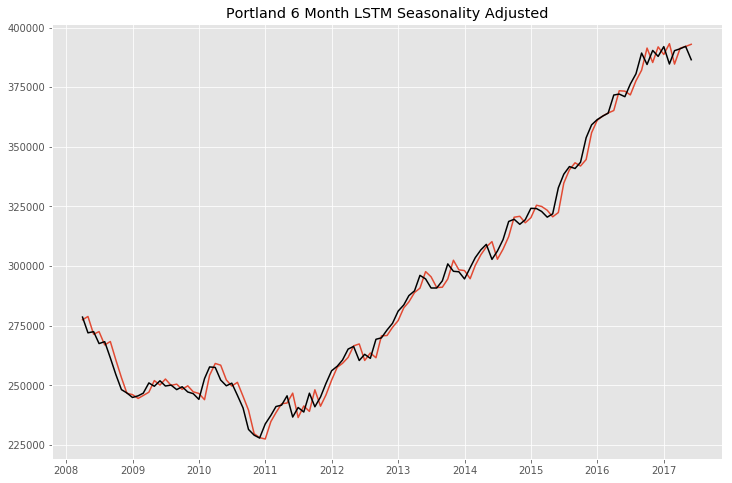

In [65]:
lstm_pred.set_index(y.index, inplace=True) # Set index to percent change lstm predictions
predicted_pct_change = lstm_pred.rename(index=str, columns={0: 'predicted pct change'}) #rename column
# Concatenate predictions to real values and shift 1 to match up for multiplication
prediction = pd.concat([predicted_pct_change, portland_6_month[['predict']].shift(1).dropna()], axis=1, join='inner')
# multiply 1 + predicted percent change by the actual value to get the predicted value
prediction['predicted value'] = (1 + prediction['predicted pct change']) * prediction['predict']
# reset index and change to date time
prediction.reset_index(inplace=True)
prediction['month'] = pd.to_datetime(prediction['month'])
prediction.set_index('month', inplace=True)
print(prediction.head())

# Get the Mean squared error and find the error in dollar terms
print(("MSE: %0.2f" % mean_squared_error(portland_6_month[['predict']][1:], prediction['predicted value'])))
print(("Error: $%0.2f" % np.sqrt(mean_squared_error(portland_6_month[['predict']][1:], prediction['predicted value']))))

# Plot final
plt.figure(figsize=(12,8))
plt.title('Portland 6 Month LSTM Seasonality Adjusted')
plt.plot(prediction['predicted value'])
plt.plot(portland_6_month['predict'][1:], color='black')
plt.savefig('LSTM Seasonality 6 month.jpg');

# Recurrent Neural Network (12 months)

In [66]:
# Create a dataframe from new sale_price df
# reset the index of dates into a column and change label
portland = pd.DataFrame(df.iloc[0, 4:])
portland.reset_index(inplace=True)  
portland.columns = ['month', 'portland']
portland.head(2)

# Convert the month column into data time format
# Convert portland into integer format
portland['month'] = pd.to_datetime(portland['month'])
portland['portland'] = portland['portland'].astype(int)
# portland.dtypes

# Set the index back to the date time info
portland = portland.set_index('month')

# Data looks ready for time series analysis
portland.head(5)

,portland
month,
2008-03-01,288100
2008-04-01,278800
2008-05-01,277200
2008-06-01,278000
2008-07-01,283000


In [67]:
cc = dataout(12)
cc.dropna(axis=0, inplace=True)
# cc.tail(12)
portland_12_month = cc

In [68]:
portland_12_month.rename(columns={'portland': 'pdx -12', 1:'pdx -11', 2:'pdx -10', 
                                   3:'pdx -9', 4:'pdx -8', 5:'pdx -7', 
                                   6:'pdx -6', 7:'pdx -5', 8:'pdx -4', 
                                   9:'pdx -3', 10:'pdx -2', 11:'pdx -1'}, inplace=True)
print(portland_12_month.shape)
portland_12_month.tail(5)

(106, 13)


,pdx -12,pdx -11,pdx -10,pdx -9,pdx -8,pdx -7,pdx -6,pdx -5,pdx -4,pdx -3,pdx -2,pdx -1,predict
month,,,,,,,,,,,,,
2016-08-01,362900,364100.0,371700.0,372100.0,371000.0,376300.0,380600.0,389300.0,384500.0,390400.0,387900.0,392000.0,384700.0
2016-09-01,364100,371700.0,372100.0,371000.0,376300.0,380600.0,389300.0,384500.0,390400.0,387900.0,392000.0,384700.0,390300.0
2016-10-01,371700,372100.0,371000.0,376300.0,380600.0,389300.0,384500.0,390400.0,387900.0,392000.0,384700.0,390300.0,391100.0
2016-11-01,372100,371000.0,376300.0,380600.0,389300.0,384500.0,390400.0,387900.0,392000.0,384700.0,390300.0,391100.0,392100.0
2016-12-01,371000,376300.0,380600.0,389300.0,384500.0,390400.0,387900.0,392000.0,384700.0,390300.0,391100.0,392100.0,386500.0


dict_keys(['loss', 'mean_squared_error'])


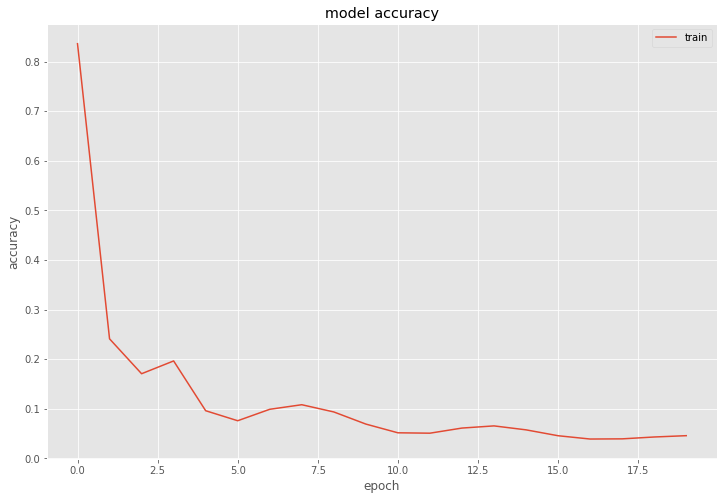

In [69]:
# Assign the values to X and y variables
# The predict column(y) and the shifted data(X)
X = portland_12_month.iloc[:,0:12]
y = portland_12_month[['predict']]

# assign the real sale price to a variable
y_real = y['predict'].as_matrix()

# Train test split, don't shuffle the data for time series
# Scale the data
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False) 

ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

y_train_sc = ss.fit_transform(y_train)
y_test_sc = ss.transform(y_test)

# Reshape the data into 3d for the RNN-LSTM model
X_train_sc = X_train_sc.reshape(X_train_sc.shape[0], X_train_sc.shape[1], 1)
X_test_sc = X_test_sc.reshape(X_test_sc.shape[0], X_test_sc.shape[1], 1)

# print(X_train_sc.shape)
# print(X_train.shape)
# print(y_train.shape)

model = Sequential()
model.add(LSTM(200, activation='tanh', input_shape=(X_train_sc.shape[1], 1) ))
model.add(Dense(200, activation='tanh'))
model.add(Dense(1, activation='linear'))
adam = optimizers.adam(lr=0.002,decay=0.0002)
model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mean_squared_error'])

history_portland_12_month = model.fit(X_train_sc, y_train_sc, epochs = 20, batch_size=len(X), shuffle=False, verbose=0)
# list all data in history
print(history_portland_12_month.history.keys())

# summarize history for accuracy
plt.figure(figsize=(12,8))
plt.plot(history_portland_12_month.history['mean_squared_error'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# too many neurons hurts, too many layers may not help
# more layers helps
# more neurons helps
# play with the activation function, regression vs classification important
# how to get performance better, layers, epochs neurons
# diminishing returns after a certain number of neurons

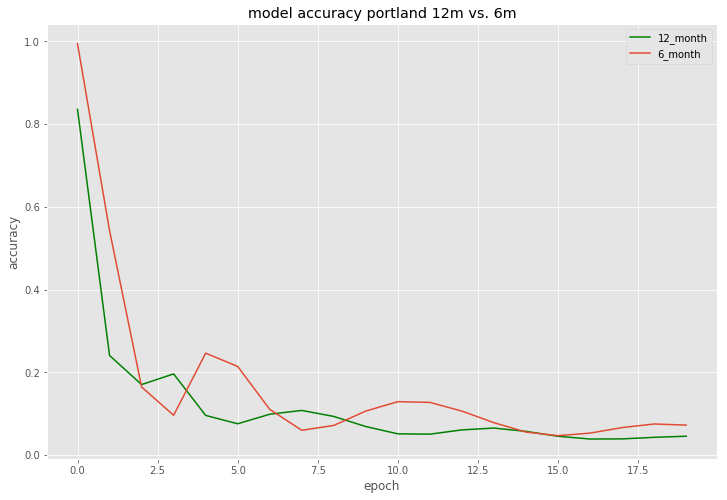

In [70]:
# list all data in history
# print(history_portland_12_month.history.keys())

# summarize history for accuracy
plt.figure(figsize=(12,8))
plt.plot(history_portland_12_month.history['mean_squared_error'],color='green')
plt.plot(history_portland_6_month.history['mean_squared_error'])
plt.title('model accuracy portland 12m vs. 6m')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['12_month', '6_month'], loc='upper right')
plt.show()

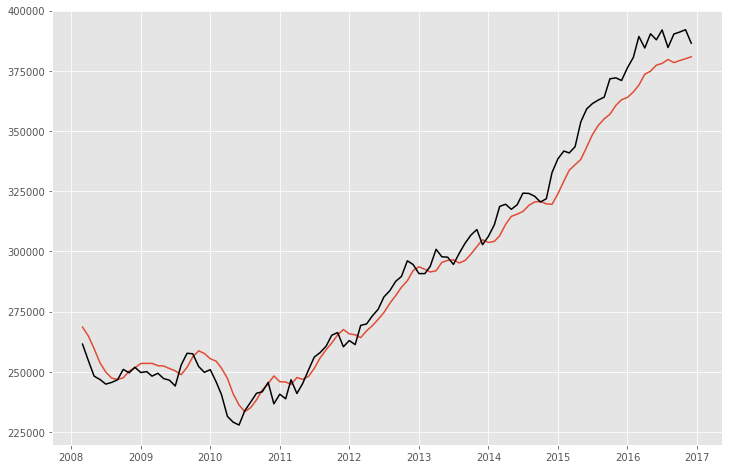

In [71]:
# Transform train data back to previous format
lstm_train_prediction = ss.inverse_transform(model.predict(X_train_sc))

# Transform test data back to previous format
lstm_test_prediction = ss.inverse_transform(model.predict(X_test_sc))

# Concatenate the train and test predictions for plotting
lstm_pred = pd.concat([pd.DataFrame(lstm_train_prediction, index=(X_train.index)), 
                       pd.DataFrame(lstm_test_prediction, index=(X_test.index))])

# Check length of the predictions 
# len(lstm_pred)

# Check the index from portland
# portland.index

# Reset index for the predictions to double check the accuracy of dates
lstm_pred = lstm_pred.reset_index()
# lstm_pred.head()

# drop the month to conform with format of plot
lstm_pred.drop(['month'], axis=1, inplace=True)

plt.figure(figsize=(12,8))
plt.plot(portland_12_month.index.values, lstm_pred)
plt.plot(portland_12_month.index.values, y_real, color='black');
# add a semicolon to remove the text line

In [72]:
print("Error: $%0.2f" % np.sqrt(ss.inverse_transform(history_portland_12_month.history['mean_squared_error']).sum()))

Error: $2331.16


# SF 6 month LSTM-RNN Model

In [73]:
# Create a dataframe from new sale_price df
# reset the index of dates into a column and change label
sf = pd.DataFrame(ca_df.iloc[3, 4:])
sf.dropna(inplace=True)


sf.reset_index(inplace=True)  
sf.columns = ['month', 'sf']
sf.head(2)

# Convert the month column into data time format
# Convert portland into integer format
sf['month'] = pd.to_datetime(sf['month'])
sf['sf'] = sf['sf'].astype(int)
# sf.dtypes

# Set the index back to the date time info
sf = sf.set_index('month')

# Data looks ready for time series analysis
sf.head(2)

,sf
month,
2008-03-01,788400
2008-04-01,775400


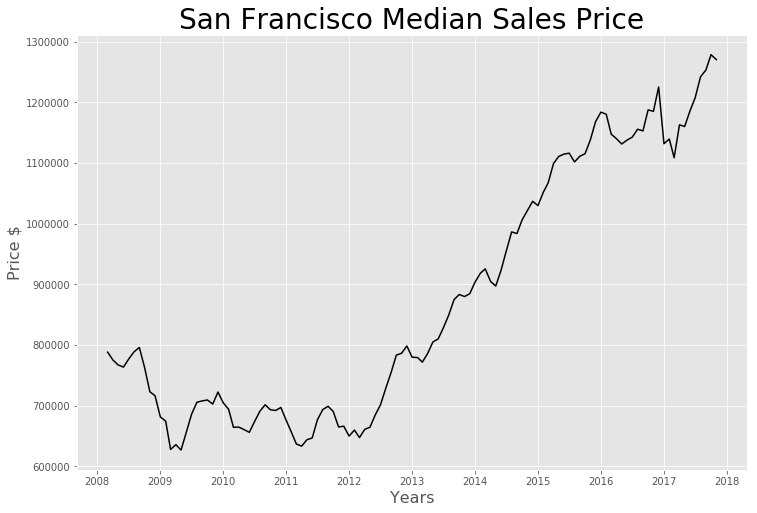

In [74]:
plt.figure(figsize=(12,8))
plt.title('San Francisco Median Sales Price', fontsize=28)
plt.ylabel('Price $', fontsize=16)
plt.xlabel('Years', fontsize=16)
plt.plot(sf.index, sf['sf'], color='black');
# plt.legend(portland_rnn,loc='upper left')
plt.savefig('SF Median Sales Price.jpg');

In [75]:
def dataout(duration):
    for i in range (1, duration+1):
        j = -1 * i 
        if i == (duration):
            sf['predict'] = sf['sf'].shift(j) 
        else:
            sf[i] = sf['sf'].shift(j) 
    return sf

cc = dataout(6)
cc.dropna(axis=0, inplace=True)
cc.tail(10)
sf_6_month = cc
sf_6_month.rename(columns={'sf': 'sf - 6', 1:'sf - 5', 2:'sf - 4', 3:'sf - 3', 4:'sf - 2', 5:'sf - 1'}, inplace=True)
sf_6_month.tail(5)

,sf - 6,sf - 5,sf - 4,sf - 3,sf - 2,sf - 1,predict
month,,,,,,,
2017-01-01,1132000,1139700.0,1108800.0,1163100.0,1160300.0,1186100.0,1207700.0
2017-02-01,1139700,1108800.0,1163100.0,1160300.0,1186100.0,1207700.0,1242200.0
2017-03-01,1108800,1163100.0,1160300.0,1186100.0,1207700.0,1242200.0,1253200.0
2017-04-01,1163100,1160300.0,1186100.0,1207700.0,1242200.0,1253200.0,1278700.0
2017-05-01,1160300,1186100.0,1207700.0,1242200.0,1253200.0,1278700.0,1270600.0


dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])


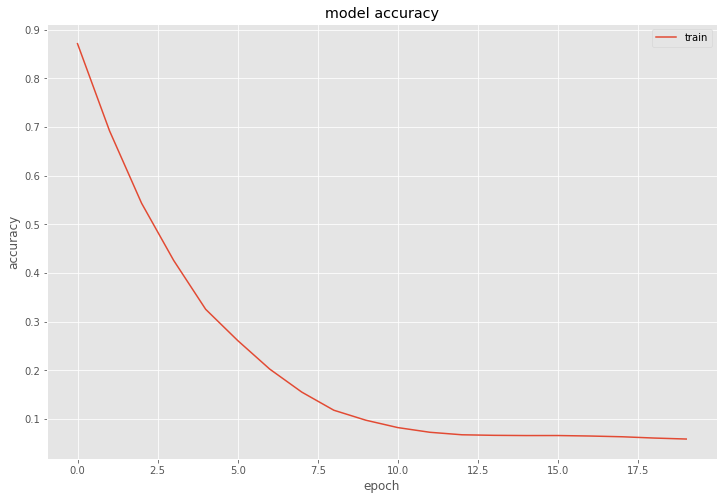

In [76]:
# Assign the values to X and y variables
# The predict column(y) and the shifted data(X)
X = sf_6_month.iloc[:,0:6]
y = sf_6_month[['predict']]

y_real = y['predict'].as_matrix()

# Train test split, don't shuffle the data for time series
# Scale the data
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False) 

ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

y_train_sc = ss.fit_transform(y_train)
y_test_sc = ss.transform(y_test)

# Reshape the data into 3d for the RNN-LSTM model
X_train_sc = X_train_sc.reshape(X_train_sc.shape[0], X_train_sc.shape[1], 1)
X_test_sc = X_test_sc.reshape(X_test_sc.shape[0], X_test_sc.shape[1], 1)

# X_train_sc.shape
# X_train.shape
# y_train.shape

model = Sequential()
model.add(LSTM(100, activation='tanh', input_shape=(X_train_sc.shape[1], 1)))
model.add(Dense(100, activation='tanh'))
model.add(Dense(1, activation='linear'))
adam = optimizers.adam(lr=0.01,decay=0.002)
model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mean_squared_error'])

history_sf_6_month = model.fit(X_train_sc, y_train_sc, epochs = 15, batch_size=len(X), shuffle=False, verbose=0)
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.figure(figsize=(12,8))
plt.plot(history.history['mean_squared_error'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# stateful=True, try later batch size must be chosen

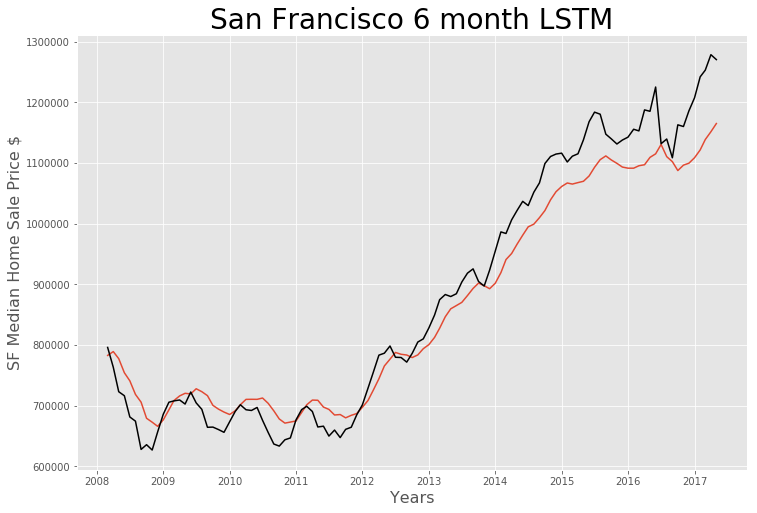

In [80]:
# Transform train data back to previous format
lstm_train_prediction = ss.inverse_transform(model.predict(X_train_sc))

# Transform test data back to previous format
lstm_test_prediction = ss.inverse_transform(model.predict(X_test_sc))

# Concatenate the train and test predictions for plotting
lstm_pred = pd.concat([pd.DataFrame(lstm_train_prediction, index=(X_train.index)), 
                       pd.DataFrame(lstm_test_prediction, index=(X_test.index))])

# Check length of the predictions 
# len(lstm_pred)

# Check the index from portland
# sf.index

# Reset index for the predictions to double check the accuracy of dates
lstm_pred = lstm_pred.reset_index()
# lstm_pred.head()

# drop the month to conform with format of plot
lstm_pred.drop(['month'], axis=1, inplace=True)

plt.figure(figsize=(12,8))
plt.title('SF 6 month LSTM')
plt.title('San Francisco 6 month LSTM', fontsize=28)
plt.ylabel('SF Median Home Sale Price $', fontsize=16)
plt.xlabel('Years', fontsize=16)
plt.plot(sf_6_month.index.values, lstm_pred)
plt.plot(sf_6_month.index.values, y_real, color='black')
plt.savefig('SF_LSTM_6_month.jpeg');

In [81]:
print("SF Error: $%0.2f" % np.sqrt(ss.inverse_transform(history_sf_6_month.history['mean_squared_error']).sum()))

SF Error: $3477.22


# LSTM-RNN: (3, 6, 12 & 18 months Predict Portland Median Sale Price)

In [82]:
def month_shift(length):
    portland = pd.DataFrame(df.iloc[0, 4:]) # Create a dataframe from new sale_price df
    portland.reset_index(inplace=True) # reset the index of dates 
    portland.columns = ['month', 'portland'] # relabel columns
    portland['month'] = pd.to_datetime(portland['month']) # Convert the month column into data time format
    portland['portland'] = portland['portland'].astype(int) # Convert portland into integer format
    portland = portland.set_index('month') # Set the index back to the date time info

    # Create a function to shift the dataframe by duration (number of months of data for prediction)
    # In this case we are using 6 months of data for the prediction 
    def dataout(duration):
        for i in range (1, duration+1):
            j = -1 * i 
            if i == (duration):
                portland['predict'] = portland['portland'].shift(j) 
            else:
                portland[i] = portland['portland'].shift(j) 
        return portland

    cc = dataout(length)
    cc.dropna(axis=0, inplace=True)
    return cc

portland_3_month_1_ahead = month_shift(3)
portland_6_month_1_ahead = month_shift(6)
portland_12_month_1_ahead = month_shift(12)
portland_18_month_1_ahead = month_shift(18)

In [83]:
portland_3_month_1_ahead.tail()

,portland,1,2,predict
month,,,,
2017-05-01,390400,387900.0,392000.0,384700.0
2017-06-01,387900,392000.0,384700.0,390300.0
2017-07-01,392000,384700.0,390300.0,391100.0
2017-08-01,384700,390300.0,391100.0,392100.0
2017-09-01,390300,391100.0,392100.0,386500.0


In [84]:
# Function to create datasets to shift predict(dependent variable) one month ahead
def shift_predict_ahead(duration, portland_month):
    j = -1 * duration
    portland_month['predict'] = portland_month['predict'].shift(j)
    portland_month.dropna(axis=0, inplace=True)
    return portland_month

# Create temp file for creating 2 month shift dataset
portland_3_month_1_ahead_temp = portland_3_month_1_ahead
portland_6_month_1_ahead_temp = portland_6_month_1_ahead
portland_12_month_1_ahead_temp = portland_12_month_1_ahead
portland_18_month_1_ahead_temp = portland_18_month_1_ahead
print(portland_3_month_1_ahead.tail())

# Shift the data for 2 month ahead prediction
portland_3_month_2_ahead = shift_predict_ahead(1, portland_3_month_1_ahead_temp)
portland_6_month_2_ahead = shift_predict_ahead(1, portland_6_month_1_ahead_temp)
portland_12_month_2_ahead = shift_predict_ahead(1, portland_12_month_1_ahead_temp)
portland_18_month_2_ahead = shift_predict_ahead(1, portland_18_month_1_ahead_temp)
print(portland_3_month_2_ahead.tail())

# Create temp file for creating 3 month shift dataset
portland_3_month_2_ahead_temp = portland_3_month_2_ahead
portland_6_month_2_ahead_temp = portland_6_month_2_ahead
portland_12_month_2_ahead_temp = portland_12_month_2_ahead
portland_18_month_2_ahead_temp = portland_18_month_2_ahead

# Shift the data for 3 month ahead prediction
portland_3_month_3_ahead = shift_predict_ahead(1, portland_3_month_2_ahead_temp)
portland_6_month_3_ahead = shift_predict_ahead(1, portland_6_month_2_ahead_temp)
portland_12_month_3_ahead = shift_predict_ahead(1, portland_12_month_2_ahead_temp)
portland_18_month_3_ahead = shift_predict_ahead(1, portland_18_month_2_ahead_temp)
print(portland_3_month_3_ahead.tail())

            portland         1         2   predict
month                                             
2017-05-01    390400  387900.0  392000.0  384700.0
2017-06-01    387900  392000.0  384700.0  390300.0
2017-07-01    392000  384700.0  390300.0  391100.0
2017-08-01    384700  390300.0  391100.0  392100.0
2017-09-01    390300  391100.0  392100.0  386500.0
            portland         1         2   predict
month                                             
2017-04-01    384500  390400.0  387900.0  384700.0
2017-05-01    390400  387900.0  392000.0  390300.0
2017-06-01    387900  392000.0  384700.0  391100.0
2017-07-01    392000  384700.0  390300.0  392100.0
2017-08-01    384700  390300.0  391100.0  386500.0
            portland         1         2   predict
month                                             
2017-03-01    389300  384500.0  390400.0  384700.0
2017-04-01    384500  390400.0  387900.0  390300.0
2017-05-01    390400  387900.0  392000.0  391100.0
2017-06-01    387900  392000.0 

# Portland LSTM (m-Months, n-ahead)

In [85]:
def compare_plot(model,ss,X_train_sc, X_test_sc, X_train,X_test, y_real):
    # Transform train data back to previous format
    lstm_train_prediction = ss.inverse_transform(model.predict(X_train_sc))

    # Transform test data back to previous format
    lstm_test_prediction = ss.inverse_transform(model.predict(X_test_sc))

    # Concatenate the train and test predictions for plotting
    lstm_pred = pd.concat([pd.DataFrame(lstm_train_prediction, index=(X_train.index)), 
                           pd.DataFrame(lstm_test_prediction, index=(X_test.index))])

    # Check length of the predictions 
    #len(lstm_pred)

    # Check the index from portland
    #portland.index

    # Reset index for the predictions to double check the accuracy of dates
    lstm_pred = lstm_pred.reset_index()

    # drop the month to conform with format of plot
    lstm_pred.drop(['month'], axis=1, inplace=True)

    plt.figure(figsize=(12,8))
    plt.title('Portland LSTM', fontsize=20)
    plt.plot(lstm_pred)
    plt.plot(y_real, color='black');

In [86]:
def portland_lstm(duration,ahead):
    def shift_predict_ahead(ahead, y):
        j = -1 * (ahead - 1)
        y = y.shift(j)
        return y

# Create dataset with duration months of features to predict 1 month ahead
    X = month_shift(duration).iloc[:,0:duration]
    y = month_shift(duration)[['predict']]
    
# Shift the dependent variable ahead by "ahead" months
    y = shift_predict_ahead(ahead, y)
    portland_month = pd.concat([X,y],axis=1)
    portland_month.dropna(axis=0, inplace=True)


    y =  portland_month[['predict']] 
    X =  portland_month.iloc[:,0:duration]
    y_real = y['predict'].as_matrix()
    
# Train test split, don't shuffle the data for time series
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False) 

    # Scale the data
    ss = StandardScaler()

    X_train_sc = ss.fit_transform(X_train)
    X_test_sc = ss.transform(X_test)

    y_train_sc = ss.fit_transform(y_train)
    y_test_sc = ss.transform(y_test)

    # Reshape the data into 3d for the RNN-LSTM model
    X_train_sc = X_train_sc.reshape(X_train_sc.shape[0], X_train_sc.shape[1], 1)
    X_test_sc = X_test_sc.reshape(X_test_sc.shape[0], X_test_sc.shape[1], 1)

    model = Sequential()
    model.add(LSTM(200, activation='tanh', input_shape=(X_train_sc.shape[1], 1) ))
    model.add(Dense(200, activation='tanh'))
    model.add(Dense(1, activation='linear'))
    adam = optimizers.adam(lr=0.002,decay=0.0002)
    model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mean_squared_error'])

    print("training portland", duration, "months, predicting", ahead, "month(s) ahead")
    history_portland = model.fit(X_train_sc, y_train_sc, epochs = 25, batch_size=len(X), shuffle=False, verbose=0)
    print("done")
    compare_plot(model,ss,X_train_sc, X_test_sc, X_train,X_test, y_real)
    return history_portland
    
#     # list all data in history
#     print(history_portland.history.keys())

training portland 18 months, predicting 1 month(s) ahead
done
training portland 18 months, predicting 3 month(s) ahead
done
training portland 18 months, predicting 6 month(s) ahead
done
training portland 18 months, predicting 12 month(s) ahead
done


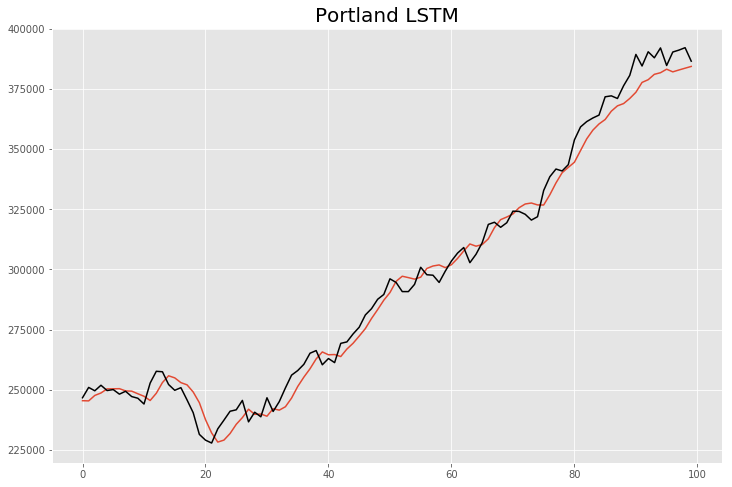

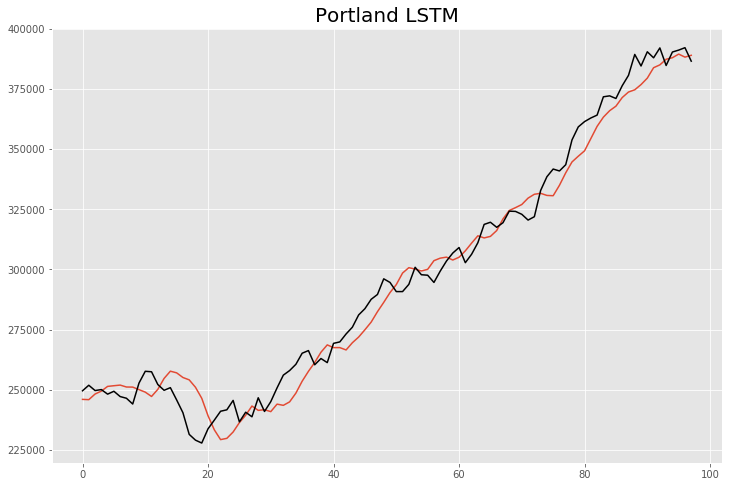

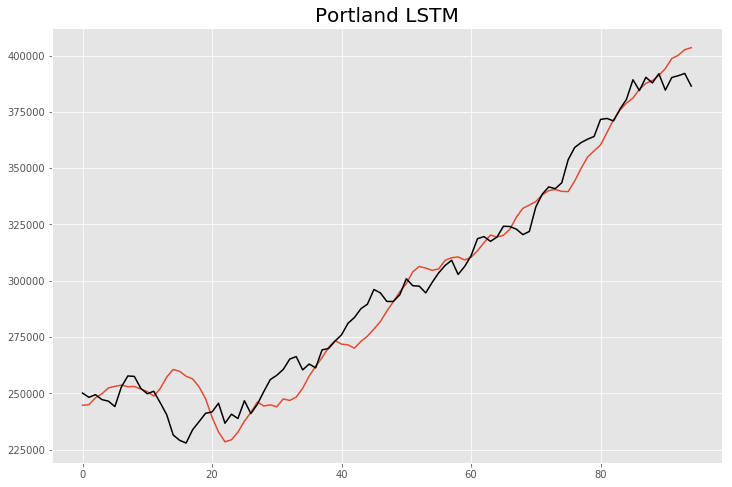

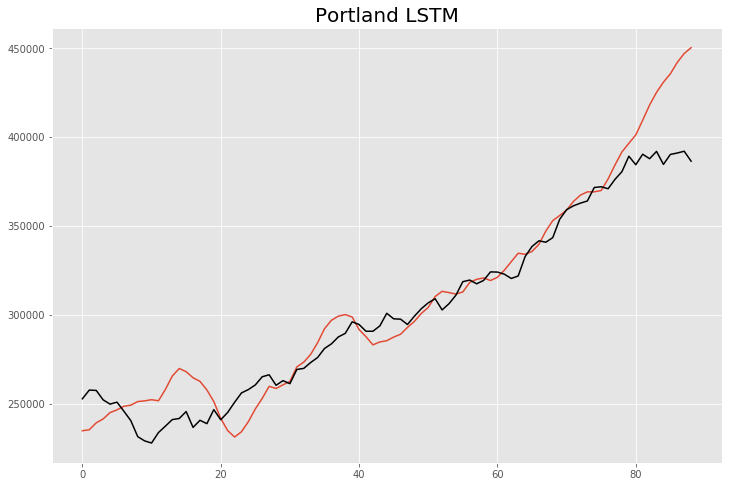

In [87]:
history_portland_18_month_1_ahead = portland_lstm(18,1)
history_portland_18_month_3_ahead = portland_lstm(18,3)
history_portland_18_month_6_ahead = portland_lstm(18,6)
history_portland_18_month_12_ahead = portland_lstm(18,12)

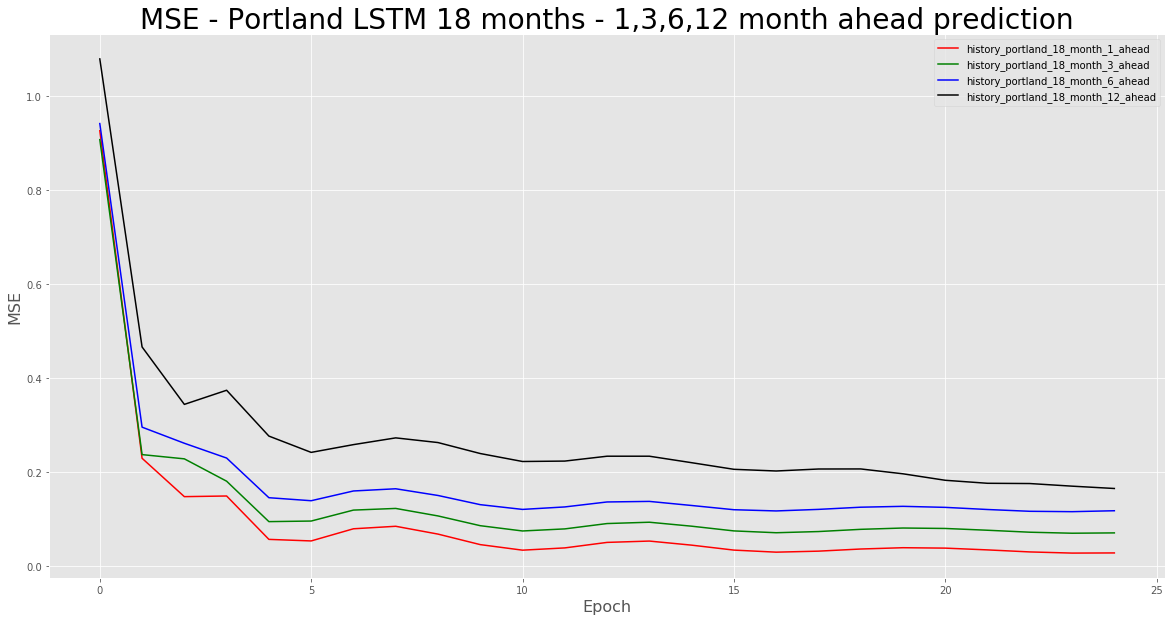

In [88]:
plt.figure(figsize=(20,10))
plt.plot(history_portland_18_month_1_ahead.history['mean_squared_error'],color='red')
plt.plot(history_portland_18_month_3_ahead.history['mean_squared_error'],color='green')
plt.plot(history_portland_18_month_6_ahead.history['mean_squared_error'],color='blue')
plt.plot(history_portland_18_month_12_ahead.history['mean_squared_error'],color='black')
plt.title('MSE - Portland LSTM 18 months - 1,3,6,12 month ahead prediction', fontsize=28)
plt.ylabel('MSE', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.legend(['history_portland_18_month_1_ahead', 'history_portland_18_month_3_ahead', 'history_portland_18_month_6_ahead', 'history_portland_18_month_12_ahead'], loc='upper right')

plt.savefig('MSE - Portland LSTM 18 month 1,3,6,12 ahead prediction.jpg')
plt.show()

In [89]:
print("Portland_3_month_1_ahead Error: $%0.2f" % np.sqrt(ss.inverse_transform(history_portland_18_month_1_ahead.history['mean_squared_error']).sum()))
print("Portland_6_month_1_ahead Error: $%0.2f" % np.sqrt(ss.inverse_transform(history_portland_18_month_3_ahead.history['mean_squared_error']).sum()))
print("Portland_12_month_1_ahead Error: $%0.2f" % np.sqrt(ss.inverse_transform(history_portland_18_month_6_ahead.history['mean_squared_error']).sum()))
print("Portland_18_month_1_ahead Error: $%0.2f" % np.sqrt(ss.inverse_transform(history_portland_18_month_12_ahead.history['mean_squared_error']).sum()))

Portland_3_month_1_ahead Error: $4456.88
Portland_6_month_1_ahead Error: $4471.85
Portland_12_month_1_ahead Error: $4489.38
Portland_18_month_1_ahead Error: $4525.98


# FED FUNDS RATE  LSTM-RNN: (3, 6, 12 & 18 months FED FUNDS RATE Predict Portland Median Sale Price)

In [90]:
# Create Fed Funds rate DataFrame
fed_funds_rate = pd.read_csv('FEDFUNDS.csv')
fed_funds_rate = fed_funds_rate[644:762]
fed_funds_rate['DATE'] = pd.to_datetime(fed_funds_rate['DATE'])
fed_funds_rate = fed_funds_rate.set_index('DATE')
print(fed_funds_rate.shape)
fed_funds_rate.head()

(118, 1)


,FEDFUNDS
DATE,
2008-03-01,2.61
2008-04-01,2.28
2008-05-01,1.98
2008-06-01,2.00
2008-07-01,2.01


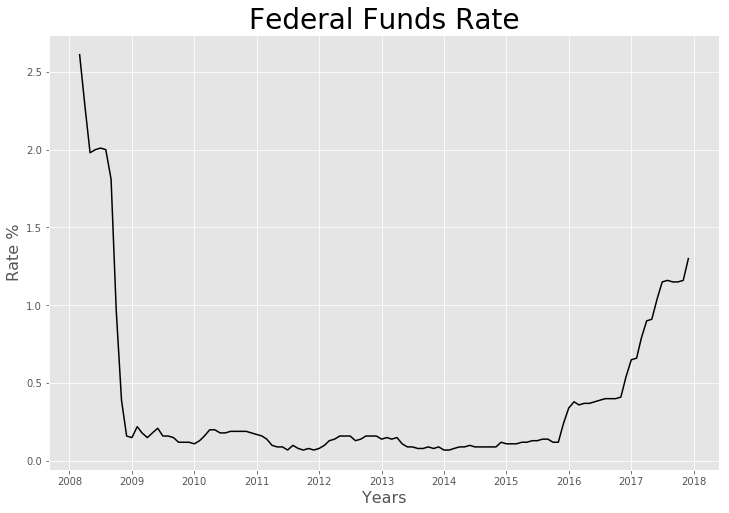

In [91]:
plt.figure(figsize=(12,8))
plt.title('Federal Funds Rate', fontsize=28)
plt.ylabel('Rate %', fontsize=16)
plt.xlabel('Years', fontsize=16)
plt.plot(fed_funds_rate, color='black')
plt.savefig('Federal Reserve Funds Rate.jpg');

In [92]:
# Create shifted dataset for Fed Funds Rate
def month_shift(length):  
    fed_funds_rate = pd.read_csv('FEDFUNDS.csv')
    fed_funds_rate = fed_funds_rate[644:762]
    fed_funds_rate['DATE'] = pd.to_datetime(fed_funds_rate['DATE'])
    fed_funds_rate = fed_funds_rate.set_index('DATE')
    # Create a function to shift the dataframe by duration (number of months of data for prediction)
    # In this case we are using 6 months of data for the prediction 
    def dataout(duration):
        for i in range (1, duration+1):
            j = -1 * i 
            if i == (duration):
                fed_funds_rate['predict'] = fed_funds_rate['FEDFUNDS'].shift(j) 
            else:
                fed_funds_rate[i] = fed_funds_rate['FEDFUNDS'].shift(j) 
        return fed_funds_rate

    cc = dataout(length)
    cc.dropna(axis=0, inplace=True)
    return cc

fed_funds_rate_18_month_1_ahead = month_shift(18)

In [93]:
# Create shifted Portland Dataframe 
def month_shift(length):
    portland = pd.DataFrame(df.iloc[0, 4:]) # Create a dataframe from new sale_price df
    portland.reset_index(inplace=True) # reset the index of dates 
    portland.columns = ['month', 'portland'] # relabel columns
    portland['month'] = pd.to_datetime(portland['month']) # Convert the month column into data time format
    portland['portland'] = portland['portland'].astype(int) # Convert portland into integer format
    portland = portland.set_index('month') # Set the index back to the date time info

    # Create a function to shift the dataframe by duration (number of months of data for prediction)
    # In this case we are using 6 months of data for the prediction 
    def dataout(duration):
        for i in range (1, duration+1):
            j = -1 * i 
            if i == (duration):
                portland['predict'] = portland['portland'].shift(j) 
            else:
                portland[i] = portland['portland'].shift(j) 
        return portland

    cc = dataout(length)
    cc.dropna(axis=0, inplace=True)
    return cc

# portland_3_month_1_ahead = month_shift(3)
# portland_6_month_1_ahead = month_shift(6)
# portland_12_month_1_ahead = month_shift(12)
portland_18_month_1_ahead = month_shift(18)

In [94]:
fed_funds_rate_18_month_1_ahead.tail(5)

,FEDFUNDS,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,predict
DATE,,,,,,,,,,,,,,,,,,,
2016-02-01,0.38,0.36,0.37,0.37,0.38,0.39,0.40,0.40,0.40,0.41,0.54,0.65,0.66,0.79,0.90,0.91,1.04,1.15,1.16
2016-03-01,0.36,0.37,0.37,0.38,0.39,0.40,0.40,0.40,0.41,0.54,0.65,0.66,0.79,0.90,0.91,1.04,1.15,1.16,1.15
2016-04-01,0.37,0.37,0.38,0.39,0.40,0.40,0.40,0.41,0.54,0.65,0.66,0.79,0.90,0.91,1.04,1.15,1.16,1.15,1.15
2016-05-01,0.37,0.38,0.39,0.40,0.40,0.40,0.41,0.54,0.65,0.66,0.79,0.90,0.91,1.04,1.15,1.16,1.15,1.15,1.16
2016-06-01,0.38,0.39,0.40,0.40,0.40,0.41,0.54,0.65,0.66,0.79,0.90,0.91,1.04,1.15,1.16,1.15,1.15,1.16,1.30


In [95]:
portland_18_month_1_ahead.tail(5)

,portland,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,predict
month,,,,,,,,,,,,,,,,,,,
2016-02-01,341700,340900.0,343500.0,353800.0,359200.0,361400.0,362900.0,364100.0,371700.0,372100.0,371000.0,376300.0,380600.0,389300.0,384500.0,390400.0,387900.0,392000.0,384700.0
2016-03-01,340900,343500.0,353800.0,359200.0,361400.0,362900.0,364100.0,371700.0,372100.0,371000.0,376300.0,380600.0,389300.0,384500.0,390400.0,387900.0,392000.0,384700.0,390300.0
2016-04-01,343500,353800.0,359200.0,361400.0,362900.0,364100.0,371700.0,372100.0,371000.0,376300.0,380600.0,389300.0,384500.0,390400.0,387900.0,392000.0,384700.0,390300.0,391100.0
2016-05-01,353800,359200.0,361400.0,362900.0,364100.0,371700.0,372100.0,371000.0,376300.0,380600.0,389300.0,384500.0,390400.0,387900.0,392000.0,384700.0,390300.0,391100.0,392100.0
2016-06-01,359200,361400.0,362900.0,364100.0,371700.0,372100.0,371000.0,376300.0,380600.0,389300.0,384500.0,390400.0,387900.0,392000.0,384700.0,390300.0,391100.0,392100.0,386500.0


In [96]:
# create new dataset to run model on
fed_funds_rate_18_month_1_ahead['predict'] = portland_18_month_1_ahead['predict']

In [97]:
fed_funds_rate_18_month_1_ahead.tail()

,FEDFUNDS,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,predict
DATE,,,,,,,,,,,,,,,,,,,
2016-02-01,0.38,0.36,0.37,0.37,0.38,0.39,0.40,0.40,0.40,0.41,0.54,0.65,0.66,0.79,0.90,0.91,1.04,1.15,384700.0
2016-03-01,0.36,0.37,0.37,0.38,0.39,0.40,0.40,0.40,0.41,0.54,0.65,0.66,0.79,0.90,0.91,1.04,1.15,1.16,390300.0
2016-04-01,0.37,0.37,0.38,0.39,0.40,0.40,0.40,0.41,0.54,0.65,0.66,0.79,0.90,0.91,1.04,1.15,1.16,1.15,391100.0
2016-05-01,0.37,0.38,0.39,0.40,0.40,0.40,0.41,0.54,0.65,0.66,0.79,0.90,0.91,1.04,1.15,1.16,1.15,1.15,392100.0
2016-06-01,0.38,0.39,0.40,0.40,0.40,0.41,0.54,0.65,0.66,0.79,0.90,0.91,1.04,1.15,1.16,1.15,1.15,1.16,386500.0


In [98]:
# Assign the values to X and y variables
# The predict column(y) and the shifted data(X)
X = fed_funds_rate_18_month_1_ahead.iloc[:,0:18]
y = fed_funds_rate_18_month_1_ahead[['predict']]

In [99]:
y_real = y['predict'].as_matrix()

In [100]:
# Train test split, don't shuffle the data for time series
# Scale the data
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False) 

ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

y_train_sc = ss.fit_transform(y_train)
y_test_sc = ss.transform(y_test)

# Reshape the data into 3d for the RNN-LSTM model
X_train_sc = X_train_sc.reshape(X_train_sc.shape[0], X_train_sc.shape[1], 1)
X_test_sc = X_test_sc.reshape(X_test_sc.shape[0], X_test_sc.shape[1], 1)

In [101]:
X_train_sc.shape

(75, 18, 1)

In [102]:
X_train.shape

(75, 18)

In [103]:
y_train.shape

(75, 1)

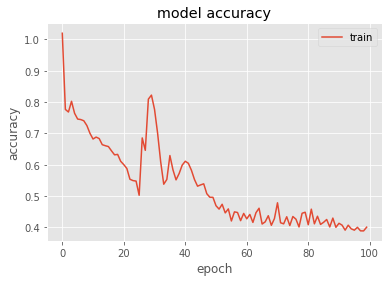

In [104]:
model = Sequential()
model.add(LSTM(400, activation='tanh', input_shape=(X_train_sc.shape[1], 1), kernel_regularizer=L1L2(l1=0.1, l2=0.0) ))
model.add(Dense(200, activation='tanh'))
model.add(Dense(1, activation='linear'))
adam = optimizers.adam(lr=0.001,decay=0.0002)
model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mean_squared_error'])

history_ffr = model.fit(X_train_sc, y_train_sc, epochs = 100, batch_size=len(X), shuffle=False, verbose=0)
# compare_plot(model,ss,X_train_sc, X_test_sc, X_train,X_test, y_real)

# summarize history for accuracy
plt.plot(history_ffr.history['mean_squared_error'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# stateful=True, try later batch size must be chosen(how do you choose and input the batch size (in fit?))
# vanishing gradient with more layers

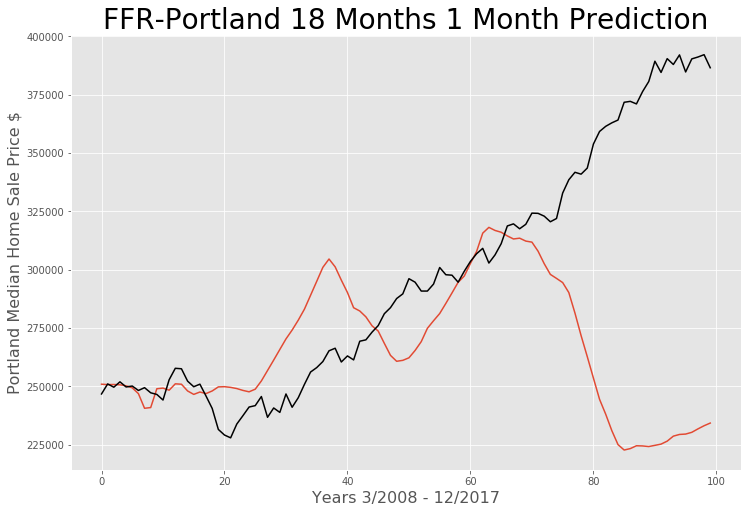

In [105]:
# Transform train data back to previous format
lstm_train_prediction = ss.inverse_transform(model.predict(X_train_sc))

# Transform test data back to previous format
lstm_test_prediction = ss.inverse_transform(model.predict(X_test_sc))

# Concatenate the train and test predictions for plotting
lstm_pred = pd.concat([pd.DataFrame(lstm_train_prediction, index=(X_train.index)), 
                       pd.DataFrame(lstm_test_prediction, index=(X_test.index))])

# Check length of the predictions 
# len(lstm_pred)

# Check the index from portland
# fed_funds_rate_12_month_1_ahead.index

# Reset index for the predictions to double check the accuracy of dates
lstm_pred = lstm_pred.reset_index()
# lstm_pred.head()

# drop the month to conform with format of plot
lstm_pred.drop(['DATE'], axis=1, inplace=True)

plt.figure(figsize=(12,8))
plt.title('FFR-Portland 18 Months 1 Month Prediction', fontsize=28)
plt.ylabel('Portland Median Home Sale Price $', fontsize=16)
plt.xlabel('Years 3/2008 - 12/2017', fontsize=16)
plt.plot(lstm_pred)
plt.plot(y_real, color='black')
plt.savefig('FFR-Portland 18 Months 1 Month Prediction');

In [106]:
print("FFR Error: $%0.2f" % np.sqrt(ss.inverse_transform(history_ffr.history['mean_squared_error']).sum()))

FFR Error: $5353.79


# UNEMPLOYMENT RATE MODEL

In [109]:
# Create Unemployment rate DataFrame
unemployment_rate = pd.read_csv('UNRATE.csv')
unemployment_rate = unemployment_rate[722:840]
unemployment_rate['DATE'] = pd.to_datetime(unemployment_rate['DATE'])
unemployment_rate = unemployment_rate.set_index('DATE')
print(unemployment_rate.shape)
unemployment_rate.tail()

(118, 1)


,UNRATE
DATE,
2017-08-01,4.4
2017-09-01,4.2
2017-10-01,4.1
2017-11-01,4.1
2017-12-01,4.1


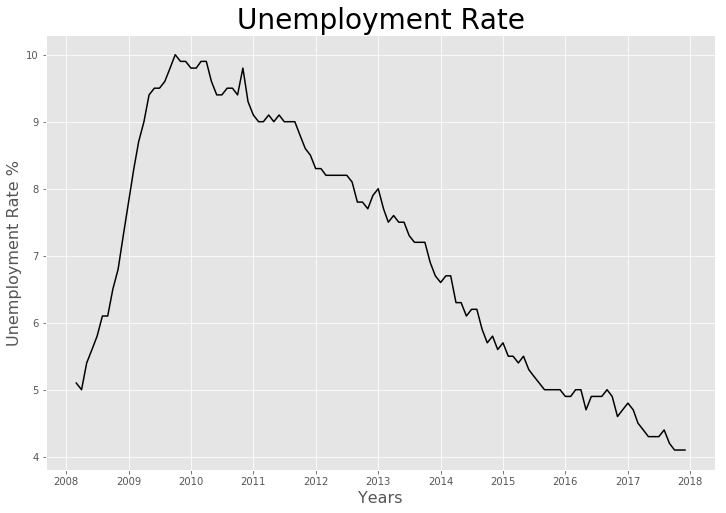

In [110]:
plt.figure(figsize=(12,8))
plt.title('Unemployment Rate', fontsize=28)
plt.ylabel('Unemployment Rate %', fontsize=16)
plt.xlabel('Years', fontsize=16)
plt.plot(unemployment_rate, color='black')
plt.savefig('Unemployment Rate.jpg');

In [111]:
# Create shifted dataset for Fed Funds Rate
def month_shift(length):  
    unemployment_rate = pd.read_csv('UNRATE.csv')
    unemployment_rate = unemployment_rate[722:840]
    unemployment_rate['DATE'] = pd.to_datetime(unemployment_rate['DATE'])
    unemployment_rate = unemployment_rate.set_index('DATE')
    # Create a function to shift the dataframe by duration (number of months of data for prediction)
    # In this case we are using 6 months of data for the prediction 
    def dataout(duration):
        for i in range (1, duration+1):
            j = -1 * i 
            if i == (duration):
                unemployment_rate['predict'] = unemployment_rate['UNRATE'].shift(j) 
            else:
                unemployment_rate[i] = unemployment_rate['UNRATE'].shift(j) 
        return unemployment_rate

    cc = dataout(length)
    cc.dropna(axis=0, inplace=True)
    return cc

unemployment_rate_18_month_1_ahead = month_shift(18)

In [112]:
# Create shifted Portland Dataframe 
def month_shift(length):
    portland = pd.DataFrame(df.iloc[0, 4:]) # Create a dataframe from new sale_price df
    portland.reset_index(inplace=True) # reset the index of dates 
    portland.columns = ['month', 'portland'] # relabel columns
    portland['month'] = pd.to_datetime(portland['month']) # Convert the month column into data time format
    portland['portland'] = portland['portland'].astype(int) # Convert portland into integer format
    portland = portland.set_index('month') # Set the index back to the date time info

    # Create a function to shift the dataframe by duration (number of months of data for prediction)
    # In this case we are using 6 months of data for the prediction 
    def dataout(duration):
        for i in range (1, duration+1):
            j = -1 * i 
            if i == (duration):
                portland['predict'] = portland['portland'].shift(j) 
            else:
                portland[i] = portland['portland'].shift(j) 
        return portland

    cc = dataout(length)
    cc.dropna(axis=0, inplace=True)
    return cc

# portland_3_month_1_ahead = month_shift(3)
# portland_6_month_1_ahead = month_shift(6)
# portland_12_month_1_ahead = month_shift(12)
portland_18_month_1_ahead = month_shift(18)

In [113]:
unemployment_rate_18_month_1_ahead.tail(5)

,UNRATE,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,predict
DATE,,,,,,,,,,,,,,,,,,,
2016-02-01,4.9,5.0,5.0,4.7,4.9,4.9,4.9,5.0,4.9,4.6,4.7,4.8,4.7,4.5,4.4,4.3,4.3,4.3,4.4
2016-03-01,5.0,5.0,4.7,4.9,4.9,4.9,5.0,4.9,4.6,4.7,4.8,4.7,4.5,4.4,4.3,4.3,4.3,4.4,4.2
2016-04-01,5.0,4.7,4.9,4.9,4.9,5.0,4.9,4.6,4.7,4.8,4.7,4.5,4.4,4.3,4.3,4.3,4.4,4.2,4.1
2016-05-01,4.7,4.9,4.9,4.9,5.0,4.9,4.6,4.7,4.8,4.7,4.5,4.4,4.3,4.3,4.3,4.4,4.2,4.1,4.1
2016-06-01,4.9,4.9,4.9,5.0,4.9,4.6,4.7,4.8,4.7,4.5,4.4,4.3,4.3,4.3,4.4,4.2,4.1,4.1,4.1


In [114]:
portland_18_month_1_ahead.tail(5)

,portland,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,predict
month,,,,,,,,,,,,,,,,,,,
2016-02-01,341700,340900.0,343500.0,353800.0,359200.0,361400.0,362900.0,364100.0,371700.0,372100.0,371000.0,376300.0,380600.0,389300.0,384500.0,390400.0,387900.0,392000.0,384700.0
2016-03-01,340900,343500.0,353800.0,359200.0,361400.0,362900.0,364100.0,371700.0,372100.0,371000.0,376300.0,380600.0,389300.0,384500.0,390400.0,387900.0,392000.0,384700.0,390300.0
2016-04-01,343500,353800.0,359200.0,361400.0,362900.0,364100.0,371700.0,372100.0,371000.0,376300.0,380600.0,389300.0,384500.0,390400.0,387900.0,392000.0,384700.0,390300.0,391100.0
2016-05-01,353800,359200.0,361400.0,362900.0,364100.0,371700.0,372100.0,371000.0,376300.0,380600.0,389300.0,384500.0,390400.0,387900.0,392000.0,384700.0,390300.0,391100.0,392100.0
2016-06-01,359200,361400.0,362900.0,364100.0,371700.0,372100.0,371000.0,376300.0,380600.0,389300.0,384500.0,390400.0,387900.0,392000.0,384700.0,390300.0,391100.0,392100.0,386500.0


In [115]:
# create new dataset to run model on
unemployment_rate_18_month_1_ahead['predict'] = portland_18_month_1_ahead['predict']

In [116]:
unemployment_rate_18_month_1_ahead.tail()

,UNRATE,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,predict
DATE,,,,,,,,,,,,,,,,,,,
2016-02-01,4.9,5.0,5.0,4.7,4.9,4.9,4.9,5.0,4.9,4.6,4.7,4.8,4.7,4.5,4.4,4.3,4.3,4.3,384700.0
2016-03-01,5.0,5.0,4.7,4.9,4.9,4.9,5.0,4.9,4.6,4.7,4.8,4.7,4.5,4.4,4.3,4.3,4.3,4.4,390300.0
2016-04-01,5.0,4.7,4.9,4.9,4.9,5.0,4.9,4.6,4.7,4.8,4.7,4.5,4.4,4.3,4.3,4.3,4.4,4.2,391100.0
2016-05-01,4.7,4.9,4.9,4.9,5.0,4.9,4.6,4.7,4.8,4.7,4.5,4.4,4.3,4.3,4.3,4.4,4.2,4.1,392100.0
2016-06-01,4.9,4.9,4.9,5.0,4.9,4.6,4.7,4.8,4.7,4.5,4.4,4.3,4.3,4.3,4.4,4.2,4.1,4.1,386500.0


In [117]:
# Assign the values to X and y variables
# The predict column(y) and the shifted data(X)
X = unemployment_rate_18_month_1_ahead.iloc[:,0:18]
y = unemployment_rate_18_month_1_ahead[['predict']]

y_real = y['predict'].as_matrix()

# Train test split, don't shuffle the data for time series
# Scale the data
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False) 

ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

y_train_sc = ss.fit_transform(y_train)
y_test_sc = ss.transform(y_test)

# Reshape the data into 3d for the RNN-LSTM model
X_train_sc = X_train_sc.reshape(X_train_sc.shape[0], X_train_sc.shape[1], 1)
X_test_sc = X_test_sc.reshape(X_test_sc.shape[0], X_test_sc.shape[1], 1)

# X_train_sc.shape
# X_train.shape
# y_train.shape

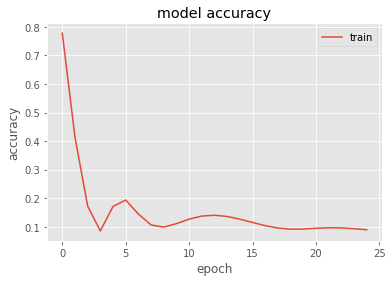

In [120]:
model = Sequential()
model.add(LSTM(200, activation='tanh', input_shape=(X_train_sc.shape[1], 1), kernel_regularizer=L1L2(l1=0.1, l2=0.0) ))
model.add(Dense(200, activation='tanh'))
model.add(Dense(1, activation='linear'))
adam = optimizers.adam(lr=0.001,decay=0.0002)
model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mean_squared_error'])

history_unemployment_rate = model.fit(X_train_sc, y_train_sc, epochs = 25, batch_size=len(X), shuffle=False, verbose=0)
# compare_plot(model,ss,X_train_sc, X_test_sc, X_train,X_test, y_real)

# summarize history for accuracy
plt.plot(history_unemployment_rate.history['mean_squared_error'])
# plt.plot(history_ur_stateful.history['mean_squared_error']) # Compare to stateful model
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# stateful=True, try later batch size must be chosen(how do you choose and input the batch size (in fit?))
# vanishing gradient with more layers

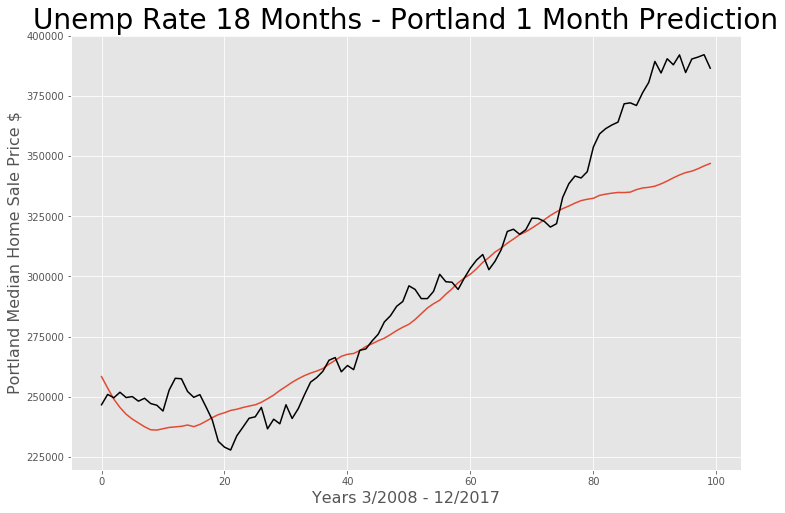

In [121]:
# Transform train data back to previous format
lstm_train_prediction = ss.inverse_transform(model.predict(X_train_sc))

# Transform test data back to previous format
lstm_test_prediction = ss.inverse_transform(model.predict(X_test_sc))

# Concatenate the train and test predictions for plotting
lstm_pred = pd.concat([pd.DataFrame(lstm_train_prediction, index=(X_train.index)), 
                       pd.DataFrame(lstm_test_prediction, index=(X_test.index))])

# Check length of the predictions 
# len(lstm_pred)

# Check the index from portland
# fed_funds_rate_12_month_1_ahead.index

# Reset index for the predictions to double check the accuracy of dates
lstm_pred = lstm_pred.reset_index()
# lstm_pred.head()

# drop the month to conform with format of plot
lstm_pred.drop(['DATE'], axis=1, inplace=True)

plt.figure(figsize=(12,8))
plt.title('Unemp Rate 18 Months - Portland 1 Month Prediction', fontsize=28)
plt.ylabel('Portland Median Home Sale Price $', fontsize=16)
plt.xlabel('Years 3/2008 - 12/2017', fontsize=16)
plt.plot(lstm_pred)
plt.plot(y_real, color='black')
plt.savefig('UR-Portland 18 Months 1 Month Prediction');

In [122]:
print("Unemployment Rate Error: $%0.2f" % np.sqrt(ss.inverse_transform(history_unemployment_rate.history['mean_squared_error']).sum()))

Unemployment Rate Error: $2625.21


# CPI 

In [123]:
# Create Unemployment rate DataFrame
cpi_rate = pd.read_csv('CPIAUCSL.csv')
cpi_rate = cpi_rate[734:852]
cpi_rate
cpi_rate['DATE'] = pd.to_datetime(cpi_rate['DATE'])
cpi_rate = cpi_rate.set_index('DATE')
print(cpi_rate.shape)
cpi_rate.tail()

(118, 1)


,CPIAUCSL
DATE,
2017-08-01,245.262
2017-09-01,246.392
2017-10-01,246.583
2017-11-01,247.411
2017-12-01,247.910


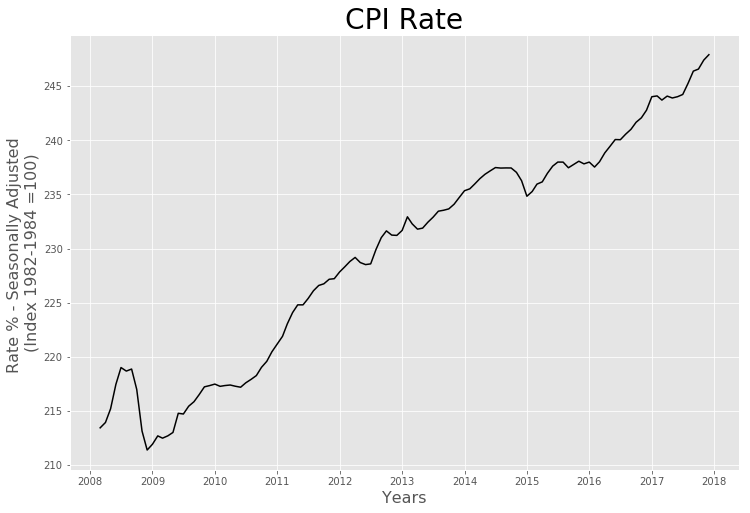

In [124]:
plt.figure(figsize=(12,8))
plt.title('CPI Rate', fontsize=28)
plt.ylabel('Rate % - Seasonally Adjusted \n(Index 1982-1984 =100)', fontsize=16)
plt.xlabel('Years', fontsize=16)
plt.plot(cpi_rate, color='black')
plt.savefig('CPI Rate.jpg');

In [125]:
# Create shifted dataset for Fed Funds Rate
def month_shift(length):  
    cpi_rate = pd.read_csv('CPIAUCSL.csv')
    cpi_rate = cpi_rate[734:852]
    cpi_rate['DATE'] = pd.to_datetime(cpi_rate['DATE'])
    cpi_rate = cpi_rate.set_index('DATE')
    # Create a function to shift the dataframe by duration (number of months of data for prediction)
    # In this case we are using 6 months of data for the prediction 
    def dataout(duration):
        for i in range (1, duration+1):
            j = -1 * i 
            if i == (duration):
                cpi_rate['predict'] = cpi_rate['CPIAUCSL'].shift(j) 
            else:
                cpi_rate[i] = cpi_rate['CPIAUCSL'].shift(j) 
        return cpi_rate

    cc = dataout(length)
    cc.dropna(axis=0, inplace=True)
    return cc

cpi_rate_18_month_1_ahead = month_shift(18)

In [126]:
# Create shifted Portland Dataframe 
def month_shift(length):
    portland = pd.DataFrame(df.iloc[0, 4:]) # Create a dataframe from new sale_price df
    portland.reset_index(inplace=True) # reset the index of dates 
    portland.columns = ['month', 'portland'] # relabel columns
    portland['month'] = pd.to_datetime(portland['month']) # Convert the month column into data time format
    portland['portland'] = portland['portland'].astype(int) # Convert portland into integer format
    portland = portland.set_index('month') # Set the index back to the date time info

    # Create a function to shift the dataframe by duration (number of months of data for prediction)
    # In this case we are using 6 months of data for the prediction 
    def dataout(duration):
        for i in range (1, duration+1):
            j = -1 * i 
            if i == (duration):
                portland['predict'] = portland['portland'].shift(j) 
            else:
                portland[i] = portland['portland'].shift(j) 
        return portland

    cc = dataout(length)
    cc.dropna(axis=0, inplace=True)
    return cc

# portland_3_month_1_ahead = month_shift(3)
# portland_6_month_1_ahead = month_shift(6)
# portland_12_month_1_ahead = month_shift(12)
portland_18_month_1_ahead = month_shift(18)

In [127]:
# create new dataset to run model on
cpi_rate_18_month_1_ahead['predict'] = portland_18_month_1_ahead['predict']

# Assign the values to X and y variables
# The predict column(y) and the shifted data(X)
X = cpi_rate_18_month_1_ahead.iloc[:,0:18]
y = cpi_rate_18_month_1_ahead[['predict']]

y_real = y['predict'].as_matrix()

# Train test split, don't shuffle the data for time series
# Scale the data
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False) 

ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

y_train_sc = ss.fit_transform(y_train)
y_test_sc = ss.transform(y_test)

# Reshape the data into 3d for the RNN-LSTM model
X_train_sc = X_train_sc.reshape(X_train_sc.shape[0], X_train_sc.shape[1], 1)
X_test_sc = X_test_sc.reshape(X_test_sc.shape[0], X_test_sc.shape[1], 1)

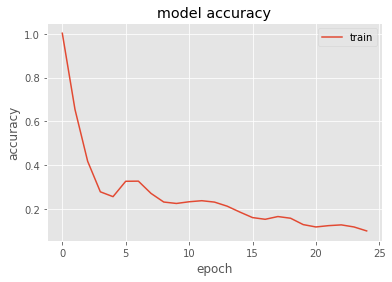

In [128]:
model = Sequential()
model.add(LSTM(200, activation='tanh', input_shape=(X_train_sc.shape[1], 1), kernel_regularizer=L1L2(l1=0.1, l2=0.0) ))
model.add(Dense(200, activation='tanh'))
model.add(Dense(1, activation='linear'))
adam = optimizers.adam(lr=0.001,decay=0.0002)
model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mean_squared_error'])

history_cpi = model.fit(X_train_sc, y_train_sc, epochs = 25, batch_size=len(X), shuffle=False, verbose=0)
# compare_plot(model,ss,X_train_sc, X_test_sc, X_train,X_test, y_real)

# summarize history for accuracy
plt.plot(history_cpi.history['mean_squared_error'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# stateful=True, try later batch size must be chosen(how do you choose and input the batch size (in fit?))
# vanishing gradient with more layers

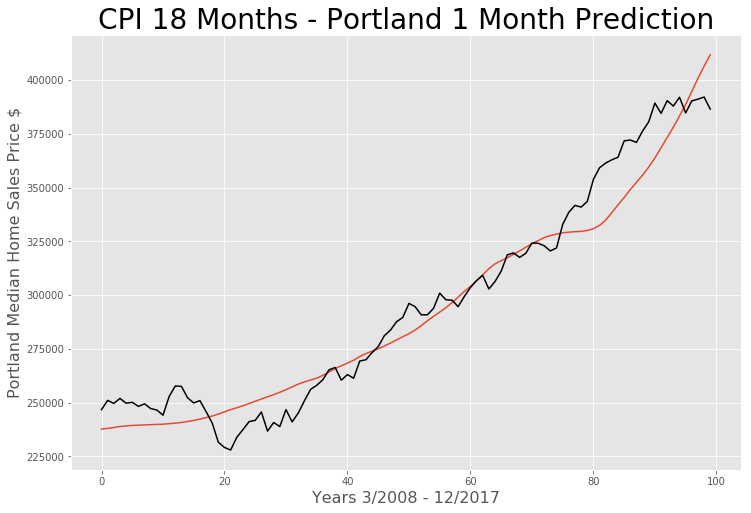

In [129]:
# Transform train data back to previous format
lstm_train_prediction = ss.inverse_transform(model.predict(X_train_sc))

# Transform test data back to previous format
lstm_test_prediction = ss.inverse_transform(model.predict(X_test_sc))

# Concatenate the train and test predictions for plotting
lstm_pred = pd.concat([pd.DataFrame(lstm_train_prediction, index=(X_train.index)), 
                       pd.DataFrame(lstm_test_prediction, index=(X_test.index))])

# Check length of the predictions 
# len(lstm_pred)

# Check the index from portland
# fed_funds_rate_12_month_1_ahead.index

# Reset index for the predictions to double check the accuracy of dates
lstm_pred = lstm_pred.reset_index()
# lstm_pred.head()

# drop the month to conform with format of plot
lstm_pred.drop(['DATE'], axis=1, inplace=True)

plt.figure(figsize=(12,8))
plt.title('CPI 18 Months - Portland 1 Month Prediction', fontsize=28)
plt.ylabel('Portland Median Home Sales Price $', fontsize=16)
plt.xlabel('Years 3/2008 - 12/2017', fontsize=16)
plt.plot(lstm_pred)
plt.plot(y_real, color='black')
plt.savefig('CPI-Portland 18 Months 1 Month Prediction');

In [130]:
print("CPI Error: $%0.2f" % np.sqrt(ss.inverse_transform(history_cpi.history['mean_squared_error']).sum()))

CPI Error: $2639.21


# PORTLAND FEATURE ENGINEERING

In [131]:
def month_shift(length):
    portland = pd.DataFrame(df.iloc[0, 4:]) # Create a dataframe from new sale_price df
    portland.reset_index(inplace=True) # reset the index of dates 
    portland.columns = ['month', 'portland'] # relabel columns
    portland['month'] = pd.to_datetime(portland['month']) # Convert the month column into data time format
    portland['portland'] = portland['portland'].astype(int) # Convert portland into integer format
    portland = portland.set_index('month') # Set the index back to the date time info

    # Create a function to shift the dataframe by duration (number of months of data for prediction)
    # In this case we are using 6 months of data for the prediction 
    def dataout(duration):
        for i in range (1, duration+1):
            j = -1 * i 
            if i == (duration):
                portland['predict'] = portland['portland'].shift(j) 
            else:
                portland[i] = portland['portland'].shift(j) 
        return portland

    cc = dataout(length)
    cc.dropna(axis=0, inplace=True)
    return cc

portland_3_month_1_ahead = month_shift(3)
portland_6_month_1_ahead = month_shift(6)
portland_12_month_1_ahead = month_shift(12)
portland_18_month_1_ahead = month_shift(18)

In [132]:
# Function to create datasets to shift predict(dependent variable) one month ahead
def shift_predict_ahead(duration, portland_month):
    j = -1 * duration
    portland_month['predict'] = portland_month['predict'].shift(j)
    portland_month.dropna(axis=0, inplace=True)
    return portland_month

# Create temp file for creating 2 month shift dataset
portland_3_month_1_ahead_temp = portland_3_month_1_ahead
portland_6_month_1_ahead_temp = portland_6_month_1_ahead
portland_12_month_1_ahead_temp = portland_12_month_1_ahead
portland_18_month_1_ahead_temp = portland_18_month_1_ahead
print(portland_3_month_1_ahead.tail())

# Shift the data for 2 month ahead prediction
portland_3_month_2_ahead = shift_predict_ahead(1, portland_3_month_1_ahead_temp)
portland_6_month_2_ahead = shift_predict_ahead(1, portland_6_month_1_ahead_temp)
portland_12_month_2_ahead = shift_predict_ahead(1, portland_12_month_1_ahead_temp)
portland_18_month_2_ahead = shift_predict_ahead(1, portland_18_month_1_ahead_temp)
print(portland_3_month_2_ahead.tail())

# Create temp file for creating 3 month shift dataset
portland_3_month_2_ahead_temp = portland_3_month_2_ahead
portland_6_month_2_ahead_temp = portland_6_month_2_ahead
portland_12_month_2_ahead_temp = portland_12_month_2_ahead
portland_18_month_2_ahead_temp = portland_18_month_2_ahead

# Shift the data for 3 month ahead prediction
portland_3_month_3_ahead = shift_predict_ahead(1, portland_3_month_2_ahead_temp)
portland_6_month_3_ahead = shift_predict_ahead(1, portland_6_month_2_ahead_temp)
portland_12_month_3_ahead = shift_predict_ahead(1, portland_12_month_2_ahead_temp)
portland_18_month_3_ahead = shift_predict_ahead(1, portland_18_month_2_ahead_temp)
print(portland_3_month_3_ahead.tail())

            portland         1         2   predict
month                                             
2017-05-01    390400  387900.0  392000.0  384700.0
2017-06-01    387900  392000.0  384700.0  390300.0
2017-07-01    392000  384700.0  390300.0  391100.0
2017-08-01    384700  390300.0  391100.0  392100.0
2017-09-01    390300  391100.0  392100.0  386500.0
            portland         1         2   predict
month                                             
2017-04-01    384500  390400.0  387900.0  384700.0
2017-05-01    390400  387900.0  392000.0  390300.0
2017-06-01    387900  392000.0  384700.0  391100.0
2017-07-01    392000  384700.0  390300.0  392100.0
2017-08-01    384700  390300.0  391100.0  386500.0
            portland         1         2   predict
month                                             
2017-03-01    389300  384500.0  390400.0  384700.0
2017-04-01    384500  390400.0  387900.0  390300.0
2017-05-01    390400  387900.0  392000.0  391100.0
2017-06-01    387900  392000.0 

# Portland LSTM

In [133]:
def compare_plot(model,ss,X_train_sc, X_test_sc, X_train,X_test, y_real):
    # Transform train data back to previous format
    lstm_train_prediction = ss.inverse_transform(model.predict(X_train_sc))

    # Transform test data back to previous format
    lstm_test_prediction = ss.inverse_transform(model.predict(X_test_sc))

    # Concatenate the train and test predictions for plotting
    lstm_pred = pd.concat([pd.DataFrame(lstm_train_prediction, index=(X_train.index)), 
                           pd.DataFrame(lstm_test_prediction, index=(X_test.index))])

    # Check length of the predictions 
    #len(lstm_pred)

    # Check the index from portland
    #portland.index

    # Reset index for the predictions to double check the accuracy of dates
    lstm_pred = lstm_pred.reset_index()

    # drop the month to conform with format of plot
    lstm_pred.drop(['month'], axis=1, inplace=True)

    plt.figure(figsize=(12,8))
    plt.title('Portland LSTM', fontsize=20)
    plt.plot(lstm_pred)
    plt.plot(y_real, color='black');

In [134]:
def portland_lstm(duration,ahead):
    def shift_predict_ahead(ahead, y):
        j = -1 * (ahead - 1)
        y = y.shift(j)
        return y

# Create dataset with duration months of features to predict 1 month ahead
    X = month_shift(duration).iloc[:,0:duration]
    y = month_shift(duration)[['predict']]
    
# Shift the dependent variable ahead by "ahead" months
    y = shift_predict_ahead(ahead, y)
    portland_month = pd.concat([X,y],axis=1)
    portland_month.dropna(axis=0, inplace=True)


    y =  portland_month[['predict']] 
    X =  portland_month.iloc[:,0:duration]
    y_real = y['predict'].as_matrix()
    
# Train test split, don't shuffle the data for time series
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False) 

    # Scale the data
    ss = StandardScaler()

    X_train_sc = ss.fit_transform(X_train)
    X_test_sc = ss.transform(X_test)

    y_train_sc = ss.fit_transform(y_train)
    y_test_sc = ss.transform(y_test)

    # Reshape the data into 3d for the RNN-LSTM model
    X_train_sc = X_train_sc.reshape(X_train_sc.shape[0], X_train_sc.shape[1], 1)
    X_test_sc = X_test_sc.reshape(X_test_sc.shape[0], X_test_sc.shape[1], 1)

    model = Sequential()
    model.add(LSTM(200, activation='tanh', input_shape=(X_train_sc.shape[1], 1) ))
    model.add(Dense(200, activation='tanh'))
    model.add(Dense(1, activation='linear'))
    adam = optimizers.adam(lr=0.001,decay=0.0002)
    model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mean_squared_error'])

    print("training portland", duration, "months, predicting", ahead, "month(s) ahead")
    history_portland = model.fit(X_train_sc, y_train_sc, epochs = 25, batch_size=len(X), shuffle=False, verbose=0)
    print("done")
    compare_plot(model, ss, X_train_sc, X_test_sc, X_train, X_test, y_real)
    return history_portland
    
#     # list all data in history
#     print(history_portland.history.keys())

training portland 3 months, predicting 1 month(s) ahead
done
training portland 6 months, predicting 1 month(s) ahead
done
training portland 12 months, predicting 1 month(s) ahead
done
training portland 18 months, predicting 1 month(s) ahead
done


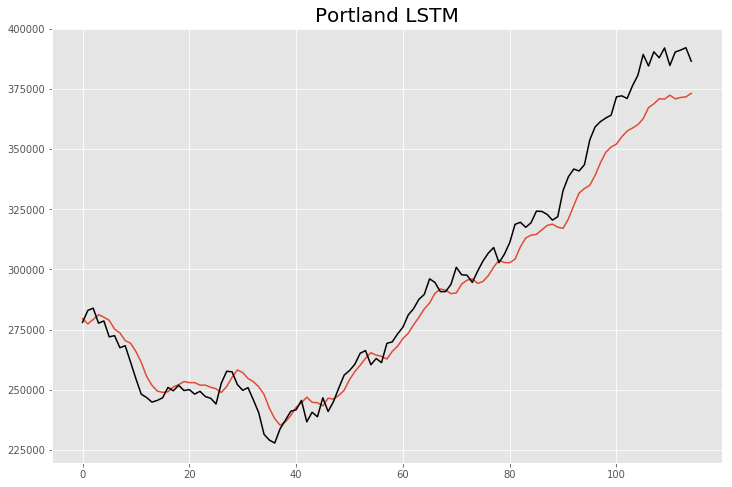

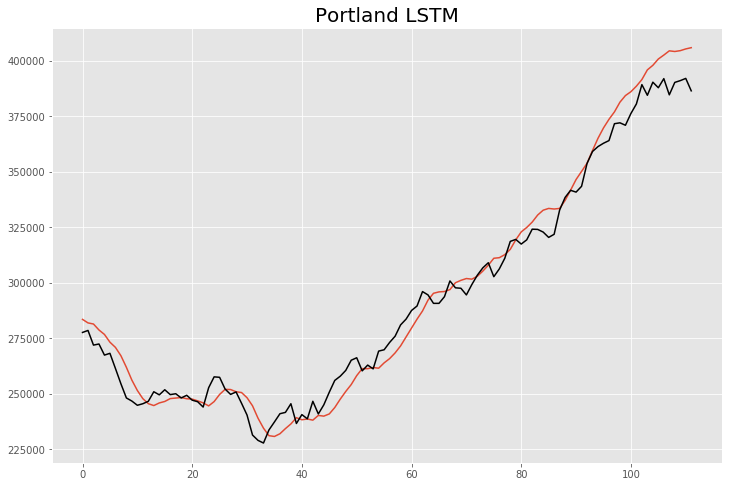

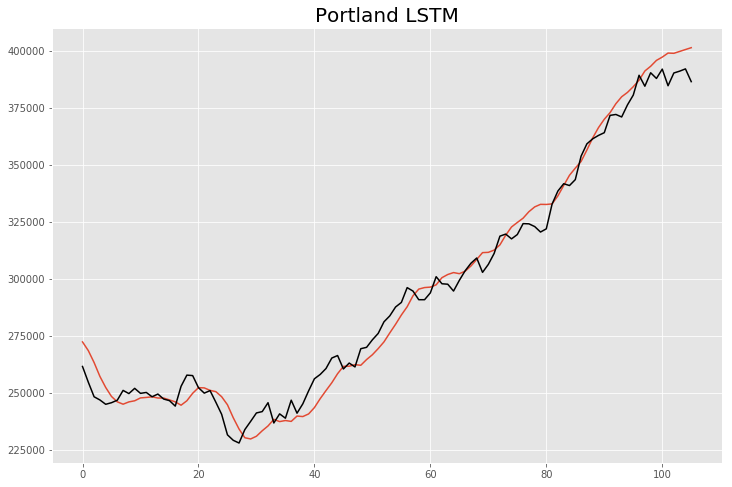

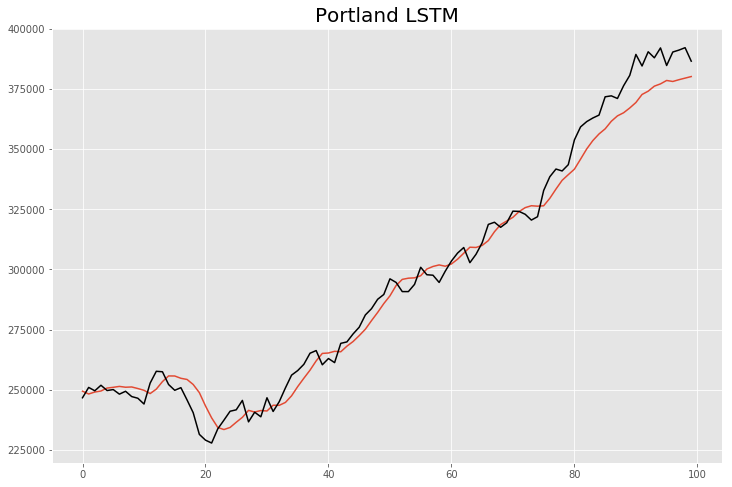

In [135]:
history_portland_3_month = portland_lstm(3,1)
history_portland_6_month = portland_lstm(6,1)
history_portland_12_month = portland_lstm(12,1)
history_portland_18_month = portland_lstm(18,1)

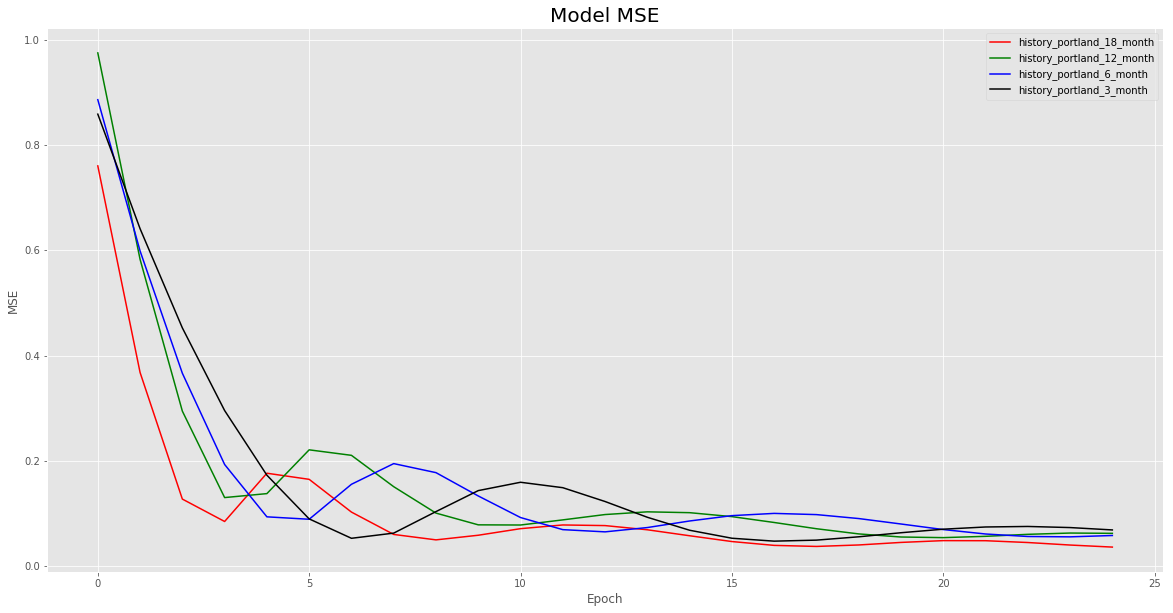

In [136]:
plt.figure(figsize=(20,10))
plt.plot(history_portland_18_month.history['mean_squared_error'],color='red')
plt.plot(history_portland_12_month.history['mean_squared_error'],color='green')
plt.plot(history_portland_6_month.history['mean_squared_error'],color='blue')
plt.plot(history_portland_3_month.history['mean_squared_error'],color='black')
plt.title('Model MSE', fontsize=20)
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['history_portland_18_month', 'history_portland_12_month', 'history_portland_6_month', 'history_portland_3_month'], loc='upper right')
# plt.savefig('1_Month_ahead.jpg')
plt.show()

# Model Using CPI, Unemployment & lag price 12 months to predict 1 month ahead

In [137]:
unemployment_rate_18_month_1_ahead.head(2)

,UNRATE,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,predict
DATE,,,,,,,,,,,,,,,,,,,
2008-03-01,5.1,5.0,5.4,5.6,5.8,6.1,6.1,6.5,6.8,7.3,7.8,8.3,8.7,9.0,9.4,9.5,9.5,9.6,246700.0
2008-04-01,5.0,5.4,5.6,5.8,6.1,6.1,6.5,6.8,7.3,7.8,8.3,8.7,9.0,9.4,9.5,9.5,9.6,9.8,251000.0


In [138]:
cpi_rate_18_month_1_ahead.head(2)

,CPIAUCSL,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,predict
DATE,,,,,,,,,,,,,,,,,,,
2008-03-01,213.448,213.942,215.208,217.463,219.016,218.690,218.877,216.995,213.153,211.398,211.933,212.705,212.495,212.709,213.022,214.790,214.726,215.445,246700.0
2008-04-01,213.942,215.208,217.463,219.016,218.690,218.877,216.995,213.153,211.398,211.933,212.705,212.495,212.709,213.022,214.790,214.726,215.445,215.861,251000.0


In [139]:
portland_18_month_1_ahead.head(2)

,portland,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,predict
month,,,,,,,,,,,,,,,,,,,
2008-03-01,288100,278800.0,277200.0,278000.0,283000.0,283900.0,277700.0,278600.0,272000.0,272500.0,267500.0,268300.0,261500.0,254600.0,248200.0,246800.0,244900.0,245600.0,249600.0
2008-04-01,278800,277200.0,278000.0,283000.0,283900.0,277700.0,278600.0,272000.0,272500.0,267500.0,268300.0,261500.0,254600.0,248200.0,246800.0,244900.0,245600.0,246700.0,251900.0


In [140]:
def month_shift(length):
    portland = pd.DataFrame(df.iloc[0, 4:]) # Create a dataframe from new sale_price df
    portland.reset_index(inplace=True) # reset the index of dates 
    portland.columns = ['month', 'portland'] # relabel columns
    portland['month'] = pd.to_datetime(portland['month']) # Convert the month column into data time format
    portland['portland'] = portland['portland'].astype(int) # Convert portland into integer format
    portland = portland.set_index('month') # Set the index back to the date time info

    # Create a function to shift the dataframe by duration (number of months of data for prediction)
    # In this case we are using 6 months of data for the prediction 
    def dataout(duration):
        for i in range (1, duration+1):
            j = -1 * i 
            if i == (duration):
                portland['predict'] = portland['portland'].shift(j) 
            else:
                portland[i] = portland['portland'].shift(j) 
        return portland

    cc = dataout(length)
    cc.dropna(axis=0, inplace=True)
    return cc

portland_3_month_1_ahead = month_shift(3)
portland_6_month_1_ahead = month_shift(6)
portland_12_month_1_ahead = month_shift(12)
portland_18_month_1_ahead = month_shift(18)

In [141]:
# create dataframe
portland_ur_cpi_18m_1a = pd.concat(
          [unemployment_rate_18_month_1_ahead.iloc[:,0:18], 
           cpi_rate_18_month_1_ahead.iloc[:,0:18], 
           portland_18_month_1_ahead.iloc[:,0:18]], 
           axis=1, ignore_index=False
)

In [142]:
portland_ur_cpi_18m_1a.head(2)

,UNRATE,1,2,3,4,5,6,7,8,9,...,8,9,10,11,12,13,14,15,16,17
2008-03-01,5.1,5.0,5.4,5.6,5.8,6.1,6.1,6.5,6.8,7.3,...,272000.0,272500.0,267500.0,268300.0,261500.0,254600.0,248200.0,246800.0,244900.0,245600.0
2008-04-01,5.0,5.4,5.6,5.8,6.1,6.1,6.5,6.8,7.3,7.8,...,272500.0,267500.0,268300.0,261500.0,254600.0,248200.0,246800.0,244900.0,245600.0,246700.0


In [143]:
portland_18_month_1_ahead.tail(2)

,portland,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,predict
month,,,,,,,,,,,,,,,,,,,
2016-05-01,353800,359200.0,361400.0,362900.0,364100.0,371700.0,372100.0,371000.0,376300.0,380600.0,389300.0,384500.0,390400.0,387900.0,392000.0,384700.0,390300.0,391100.0,392100.0
2016-06-01,359200,361400.0,362900.0,364100.0,371700.0,372100.0,371000.0,376300.0,380600.0,389300.0,384500.0,390400.0,387900.0,392000.0,384700.0,390300.0,391100.0,392100.0,386500.0


In [144]:
# Assign the values to X and y variables
# The predict column(y) and the shifted data(X)
X = portland_ur_cpi_18m_1a
y = portland_18_month_1_ahead[['predict']]

y_real = y['predict'].as_matrix()

# Train test split, don't shuffle the data for time series
# Scale the data
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False) 

ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

y_train_sc = ss.fit_transform(y_train)
y_test_sc = ss.transform(y_test)

# Reshape the data into 3d for the RNN-LSTM model
X_train_sc = X_train_sc.reshape(X_train_sc.shape[0], X_train_sc.shape[1], 1)
X_test_sc = X_test_sc.reshape(X_test_sc.shape[0], X_test_sc.shape[1], 1)

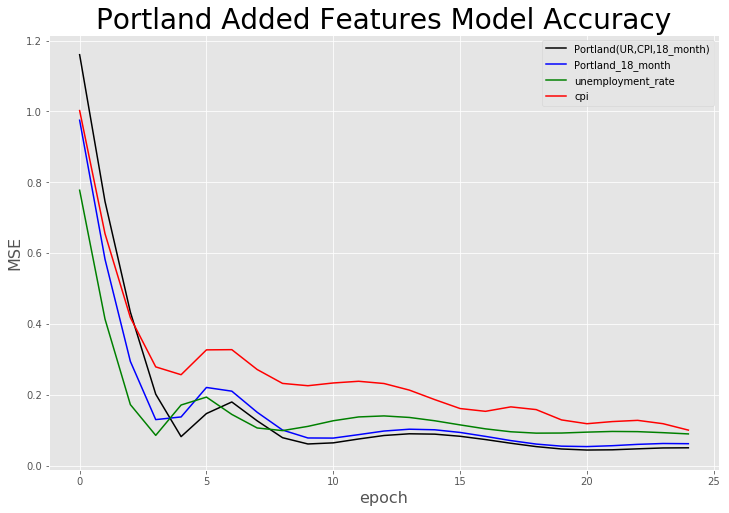

In [145]:
model = Sequential()
model.add(LSTM(200, activation='tanh', input_shape=(X_train_sc.shape[1], 1), kernel_regularizer=L1L2(l1=0.1, l2=0.0) ))
model.add(Dense(200, activation='tanh'))
model.add(Dense(1, activation='linear'))
adam = optimizers.adam(lr=0.001,decay=0.0002)
model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mean_squared_error'])

history_portland_ur_cpi_12m_1a = model.fit(X_train_sc, y_train_sc, epochs = 25, batch_size=len(X), shuffle=False, verbose=0)
# compare_plot(model,ss,X_train_sc, X_test_sc, X_train,X_test, y_real)

# summarize history for accuracy
plt.figure(figsize=(12,8))
plt.plot(history_portland_ur_cpi_12m_1a.history['mean_squared_error'], color='black')
plt.plot(history_portland_12_month.history['mean_squared_error'], color='blue')
plt.plot(history_unemployment_rate.history['mean_squared_error'], color='green')
plt.plot(history_cpi.history['mean_squared_error'], color='red')
plt.title('Portland Added Features Model Accuracy', fontsize=28)
plt.ylabel('MSE', fontsize=16)
plt.xlabel('epoch', fontsize=16)
plt.legend(['Portland(UR,CPI,18_month)', 'Portland_18_month', 'unemployment_rate', 'cpi'], loc='upper right')
plt.savefig('Added Features Portland Model Accuracy')
plt.show()

# stateful=True, try later batch size must be chosen(how do you choose and input the batch size (in fit?))
# vanishing gradient with more layers

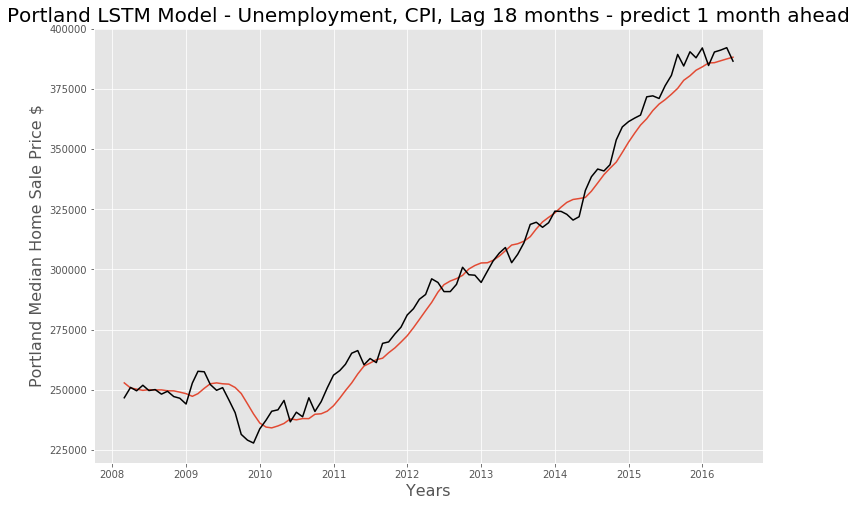

In [146]:
# Transform train data back to previous format
lstm_train_prediction = ss.inverse_transform(model.predict(X_train_sc))

# Transform test data back to previous format
lstm_test_prediction = ss.inverse_transform(model.predict(X_test_sc))

# Concatenate the train and test predictions for plotting
lstm_pred = pd.concat([pd.DataFrame(lstm_train_prediction, index=(X_train.index)), 
                       pd.DataFrame(lstm_test_prediction, index=(X_test.index))])

# Check length of the predictions 
# len(lstm_pred)

# Check the index from portland
# fed_funds_rate_12_month_1_ahead.index

# Reset index for the predictions to double check the accuracy of dates
lstm_pred = lstm_pred.reset_index()
# lstm_pred.head()

# drop the month to conform with format of plot
lstm_pred.drop(['index'], axis=1, inplace=True)

plt.figure(figsize=(12,8))
plt.title('Portland LSTM Model - Unemployment, CPI, Lag 18 months - predict 1 month ahead', fontsize=20)
plt.ylabel('Portland Median Home Sale Price $', fontsize=16)
plt.xlabel('Years', fontsize=16)
plt.plot(portland_18_month_1_ahead.index.values, lstm_pred)
plt.plot(portland_18_month_1_ahead.index.values, y_real, color='black')
plt.savefig('Portland LSTM Model - Unemployment, CPI, Lag 18 months - predict 1 month ahead');

In [147]:
print("Combined Error: $%0.2f" % np.sqrt(ss.inverse_transform(history_portland_ur_cpi_12m_1a.history['mean_squared_error']).sum()))
print("Portland 12m Error: $%0.2f" % np.sqrt(ss.inverse_transform(history_portland_12_month.history['mean_squared_error']).sum()))
print("UR Error: $%0.2f" % np.sqrt(ss.inverse_transform(history_unemployment_rate.history['mean_squared_error']).sum()))
print("CPI Error: $%0.2f" % np.sqrt(ss.inverse_transform(history_cpi.history['mean_squared_error']).sum()))

Combined Error: $2626.68
Portland 12m Error: $2625.73
UR Error: $2625.21
CPI Error: $2639.21
